# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KouichiMatsuda/GDL2/blob/main/05_autoregressive_02_pixelcnn_pixelcnn.ipynb)

In [1]:
! mkdir notebooks
%cd notebooks
! wget https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
%cd ..

/content/notebooks
--2024-06-02 09:48:32--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-06-02 09:48:33 (43.3 MB/s) - ‘utils.py’ saved [771/771]

/content


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from notebooks.utils import display

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [5]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

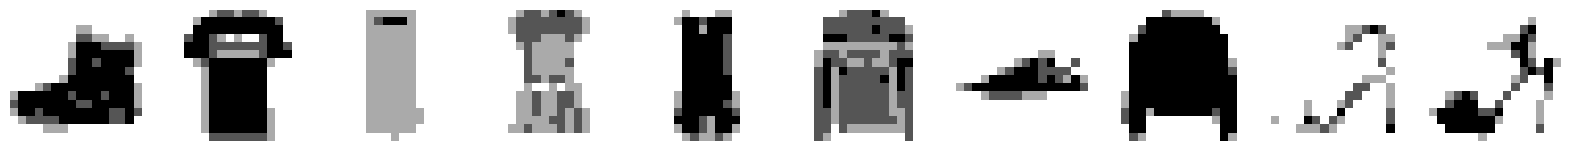

In [6]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [7]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

## 3. Train the PixelCNN <a name="train"></a>

In [10]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [11]:
!mkdir logs
!mkdir output

In [12]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
  6/469 [..............................] - ETA: 5s - loss: 1.3592     

469/469 [==============================] - ETA: 0s - loss: 0.4972
Saved to ./output/generated_img_000.png


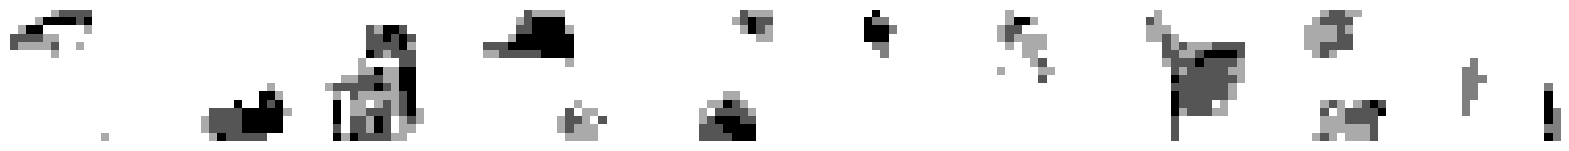

469/469 [==============================] - 35s 55ms/step - loss: 0.4972
Epoch 2/150
467/469 [============================>.] - ETA: 0s - loss: 0.4005
Saved to ./output/generated_img_001.png


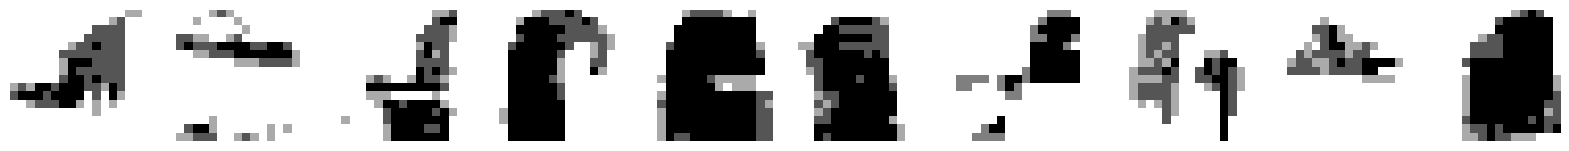

469/469 [==============================] - 24s 52ms/step - loss: 0.4004
Epoch 3/150
468/469 [============================>.] - ETA: 0s - loss: 0.3874
Saved to ./output/generated_img_002.png


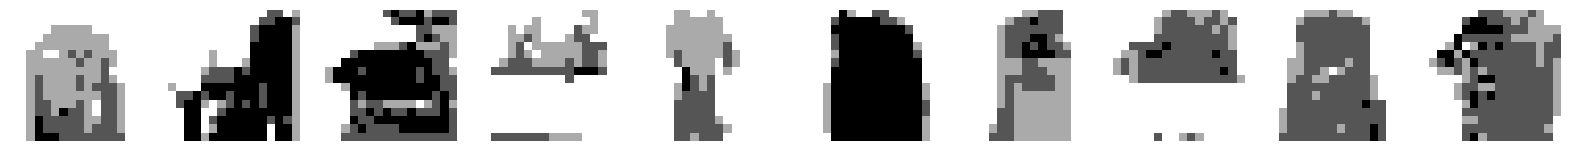

469/469 [==============================] - 25s 52ms/step - loss: 0.3875
Epoch 4/150
466/469 [============================>.] - ETA: 0s - loss: 0.3814
Saved to ./output/generated_img_003.png


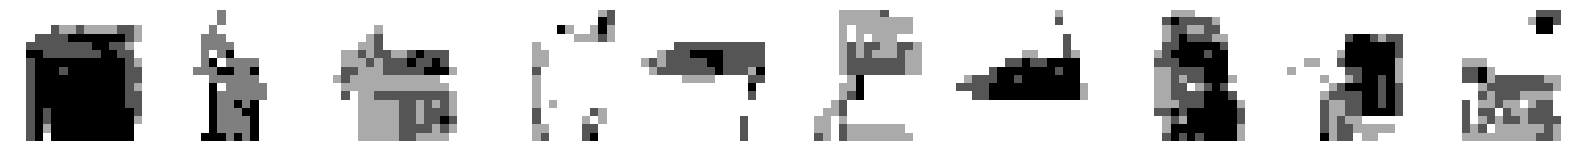

469/469 [==============================] - 24s 51ms/step - loss: 0.3813
Epoch 5/150
465/469 [============================>.] - ETA: 0s - loss: 0.3768
Saved to ./output/generated_img_004.png


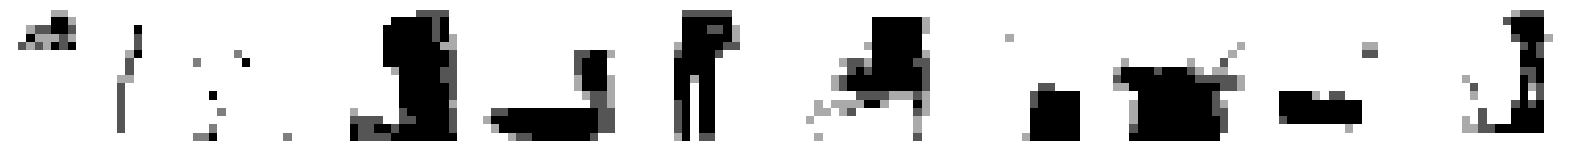

469/469 [==============================] - 24s 52ms/step - loss: 0.3767
Epoch 6/150
468/469 [============================>.] - ETA: 0s - loss: 0.3732
Saved to ./output/generated_img_005.png


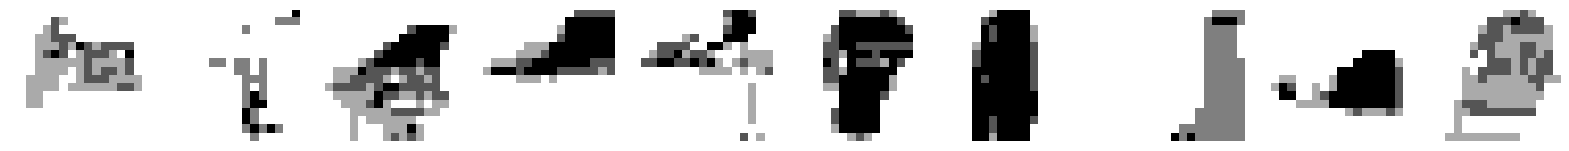

469/469 [==============================] - 25s 53ms/step - loss: 0.3732
Epoch 7/150
466/469 [============================>.] - ETA: 0s - loss: 0.3698
Saved to ./output/generated_img_006.png


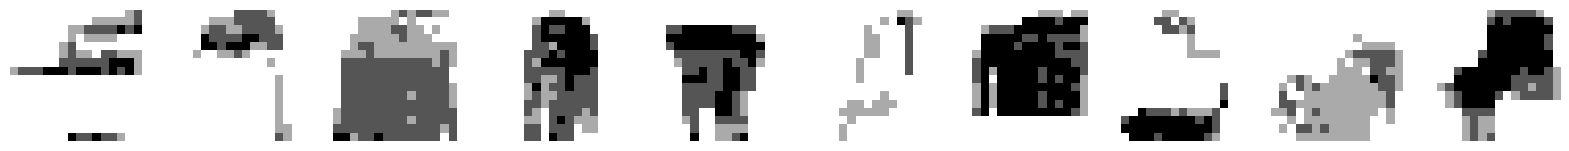

469/469 [==============================] - 24s 51ms/step - loss: 0.3698
Epoch 8/150
465/469 [============================>.] - ETA: 0s - loss: 0.3671
Saved to ./output/generated_img_007.png


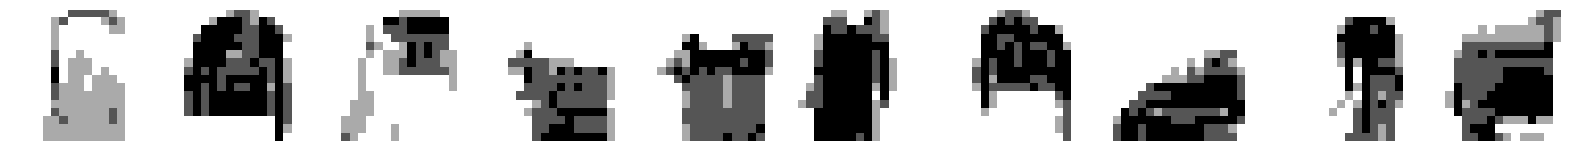

469/469 [==============================] - 24s 52ms/step - loss: 0.3672
Epoch 9/150
467/469 [============================>.] - ETA: 0s - loss: 0.3650
Saved to ./output/generated_img_008.png


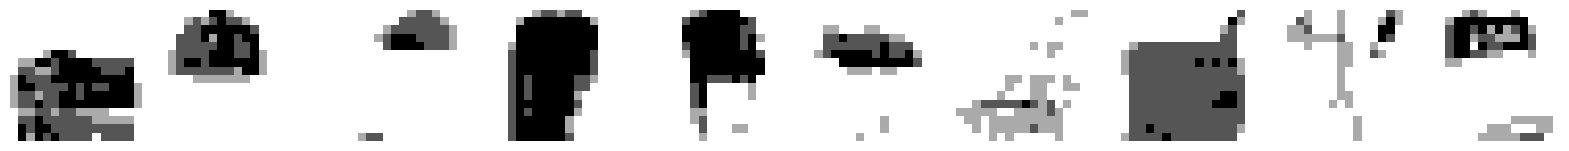

469/469 [==============================] - 24s 52ms/step - loss: 0.3650
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.3628
Saved to ./output/generated_img_009.png


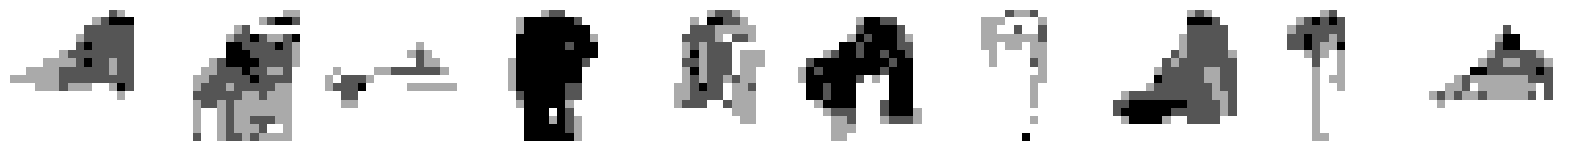

469/469 [==============================] - 24s 52ms/step - loss: 0.3628
Epoch 11/150
467/469 [============================>.] - ETA: 0s - loss: 0.3608
Saved to ./output/generated_img_010.png


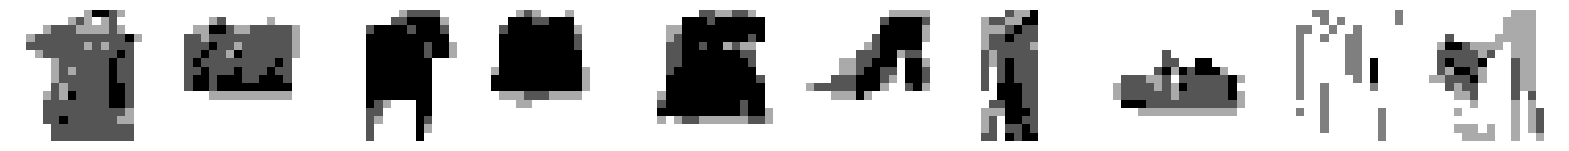

469/469 [==============================] - 25s 53ms/step - loss: 0.3607
Epoch 12/150
467/469 [============================>.] - ETA: 0s - loss: 0.3584
Saved to ./output/generated_img_011.png


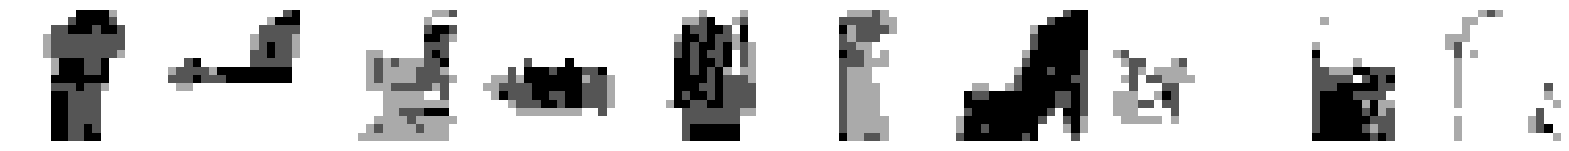

469/469 [==============================] - 24s 52ms/step - loss: 0.3585
Epoch 13/150
465/469 [============================>.] - ETA: 0s - loss: 0.3569
Saved to ./output/generated_img_012.png


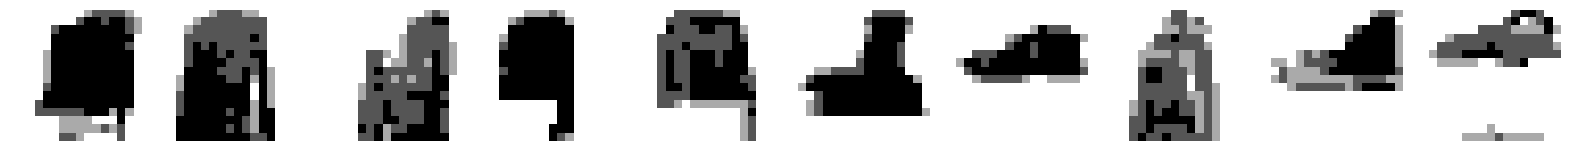

469/469 [==============================] - 25s 54ms/step - loss: 0.3569
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3558
Saved to ./output/generated_img_013.png


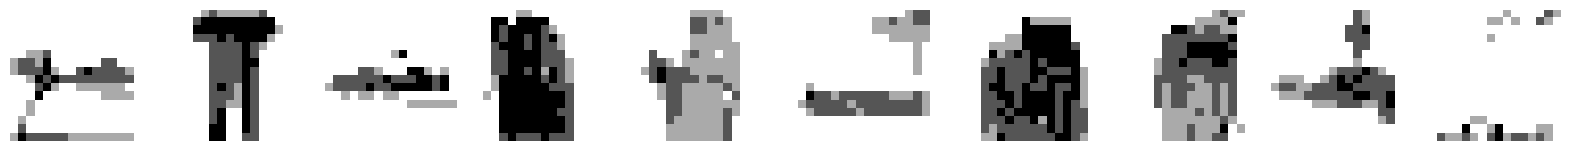

469/469 [==============================] - 25s 52ms/step - loss: 0.3558
Epoch 15/150
469/469 [==============================] - ETA: 0s - loss: 0.3541
Saved to ./output/generated_img_014.png


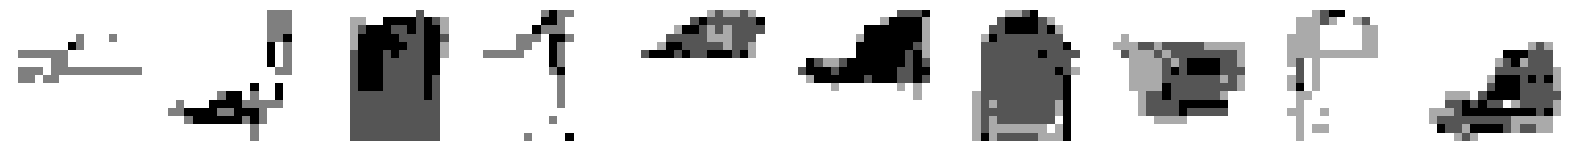

469/469 [==============================] - 24s 52ms/step - loss: 0.3541
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.3529
Saved to ./output/generated_img_015.png


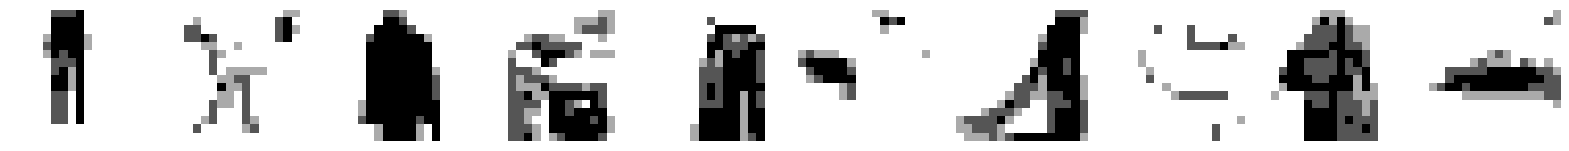

469/469 [==============================] - 25s 54ms/step - loss: 0.3529
Epoch 17/150
468/469 [============================>.] - ETA: 0s - loss: 0.3519
Saved to ./output/generated_img_016.png


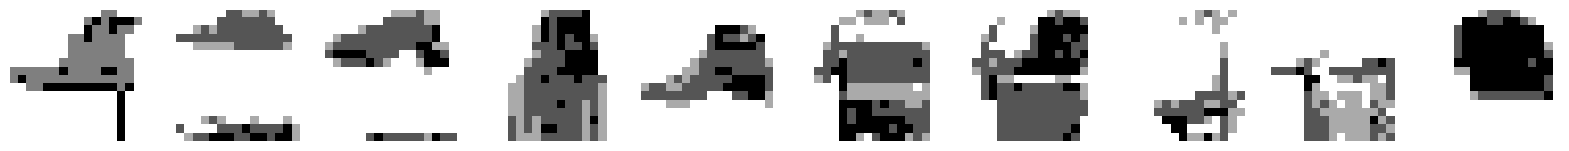

469/469 [==============================] - 24s 52ms/step - loss: 0.3519
Epoch 18/150
466/469 [============================>.] - ETA: 0s - loss: 0.3508
Saved to ./output/generated_img_017.png


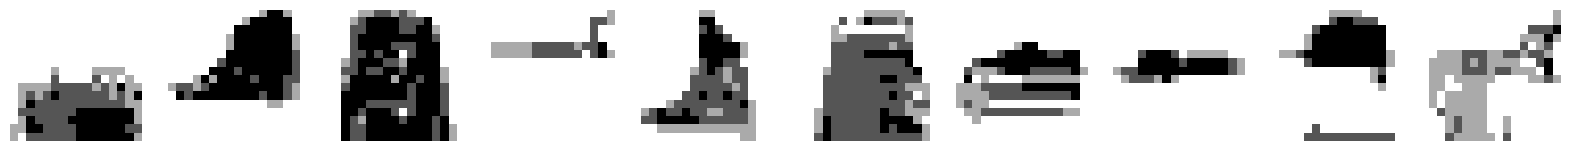

469/469 [==============================] - 25s 54ms/step - loss: 0.3507
Epoch 19/150
467/469 [============================>.] - ETA: 0s - loss: 0.3496
Saved to ./output/generated_img_018.png


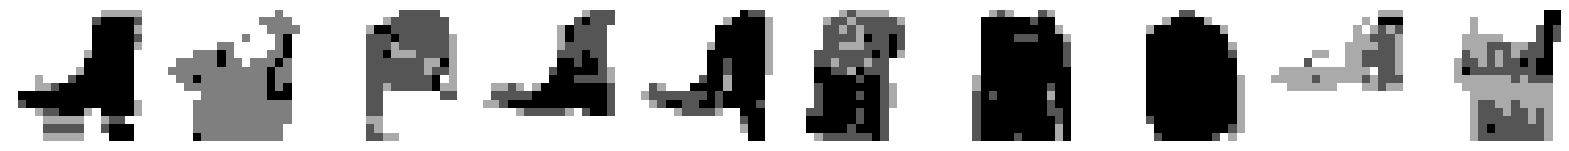

469/469 [==============================] - 25s 52ms/step - loss: 0.3495
Epoch 20/150
467/469 [============================>.] - ETA: 0s - loss: 0.3490
Saved to ./output/generated_img_019.png


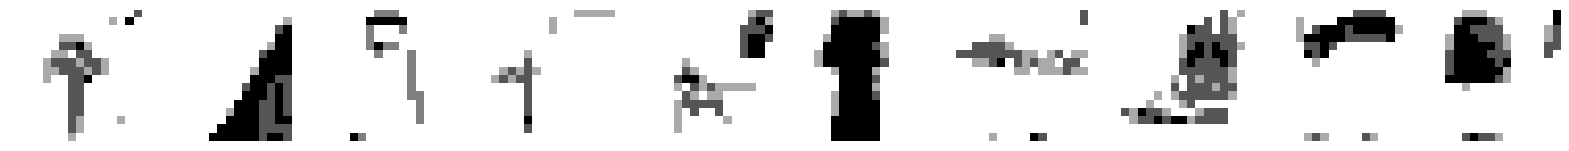

469/469 [==============================] - 25s 52ms/step - loss: 0.3490
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.3481
Saved to ./output/generated_img_020.png


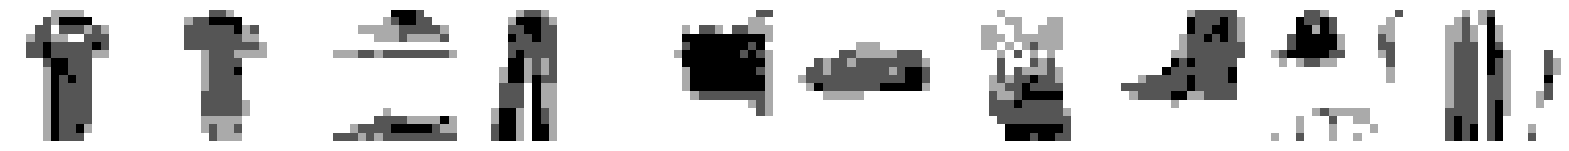

469/469 [==============================] - 26s 55ms/step - loss: 0.3481
Epoch 22/150
468/469 [============================>.] - ETA: 0s - loss: 0.3474
Saved to ./output/generated_img_021.png


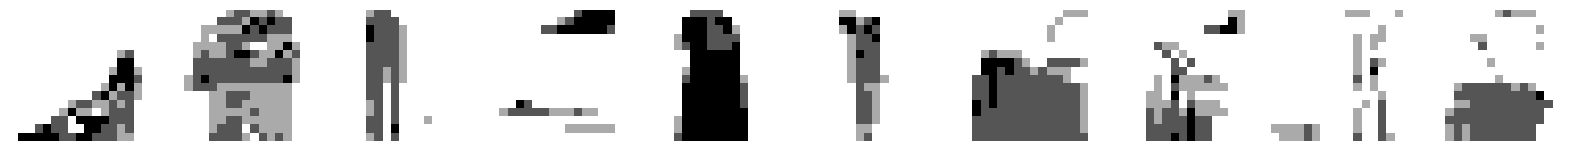

469/469 [==============================] - 24s 52ms/step - loss: 0.3474
Epoch 23/150
465/469 [============================>.] - ETA: 0s - loss: 0.3464
Saved to ./output/generated_img_022.png


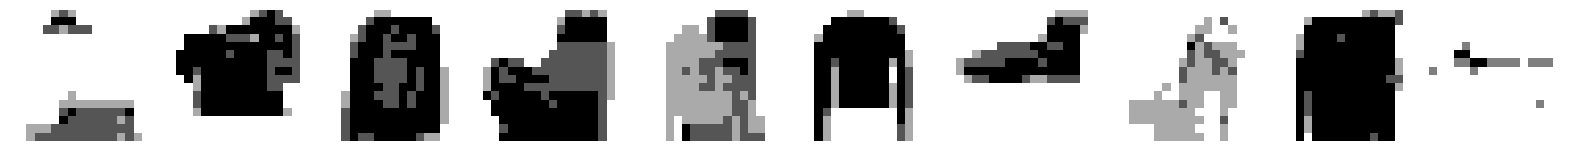

469/469 [==============================] - 25s 54ms/step - loss: 0.3465
Epoch 24/150
467/469 [============================>.] - ETA: 0s - loss: 0.3458
Saved to ./output/generated_img_023.png


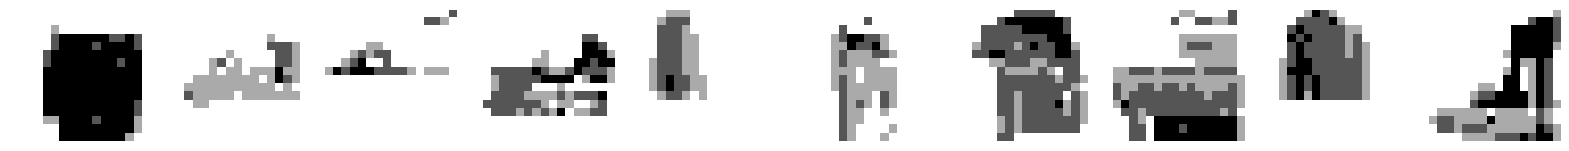

469/469 [==============================] - 25s 53ms/step - loss: 0.3458
Epoch 25/150
465/469 [============================>.] - ETA: 0s - loss: 0.3451
Saved to ./output/generated_img_024.png


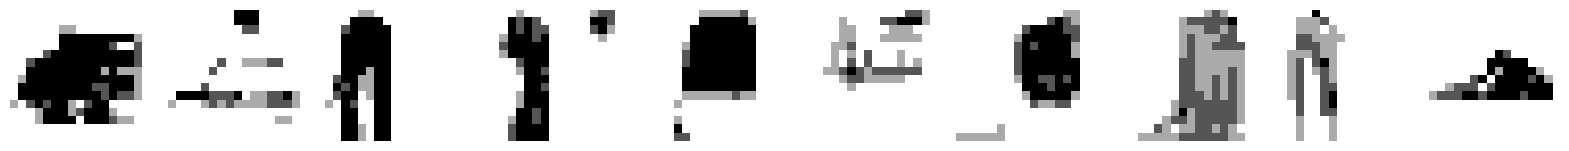

469/469 [==============================] - 24s 52ms/step - loss: 0.3451
Epoch 26/150
467/469 [============================>.] - ETA: 0s - loss: 0.3446
Saved to ./output/generated_img_025.png


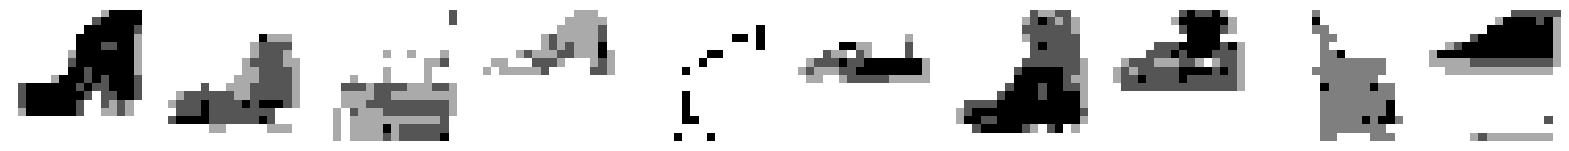

469/469 [==============================] - 26s 55ms/step - loss: 0.3446
Epoch 27/150
468/469 [============================>.] - ETA: 0s - loss: 0.3440
Saved to ./output/generated_img_026.png


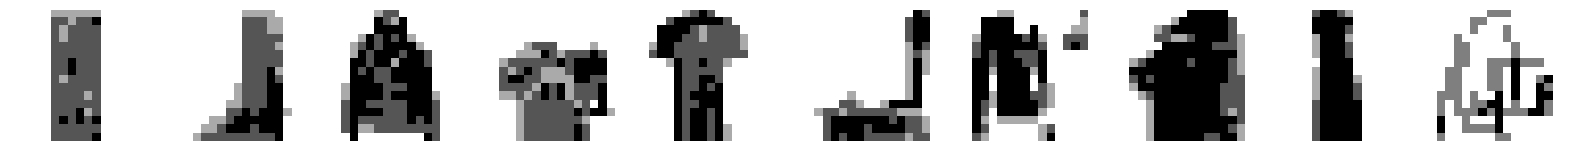

469/469 [==============================] - 24s 52ms/step - loss: 0.3440
Epoch 28/150
466/469 [============================>.] - ETA: 0s - loss: 0.3435
Saved to ./output/generated_img_027.png


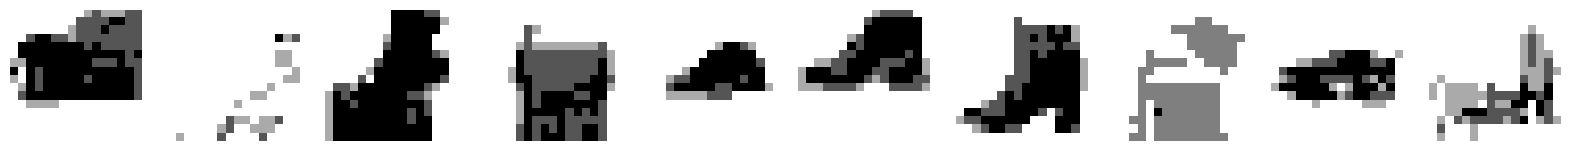

469/469 [==============================] - 26s 54ms/step - loss: 0.3435
Epoch 29/150
469/469 [==============================] - ETA: 0s - loss: 0.3431
Saved to ./output/generated_img_028.png


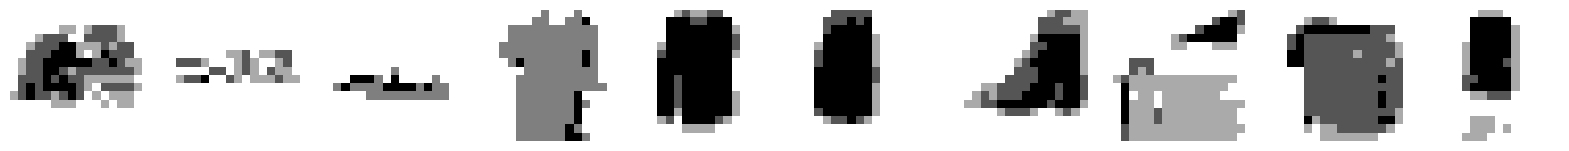

469/469 [==============================] - 25s 54ms/step - loss: 0.3431
Epoch 30/150
468/469 [============================>.] - ETA: 0s - loss: 0.3424
Saved to ./output/generated_img_029.png


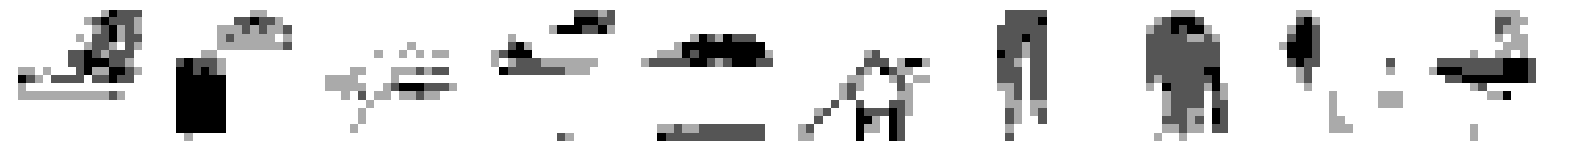

469/469 [==============================] - 24s 52ms/step - loss: 0.3424
Epoch 31/150
468/469 [============================>.] - ETA: 0s - loss: 0.3418
Saved to ./output/generated_img_030.png


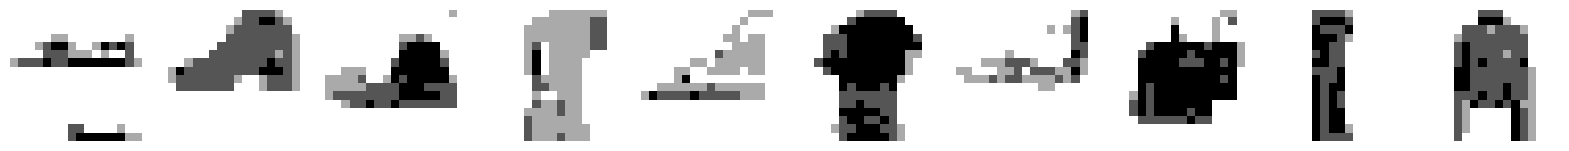

469/469 [==============================] - 26s 55ms/step - loss: 0.3418
Epoch 32/150
468/469 [============================>.] - ETA: 0s - loss: 0.3416
Saved to ./output/generated_img_031.png


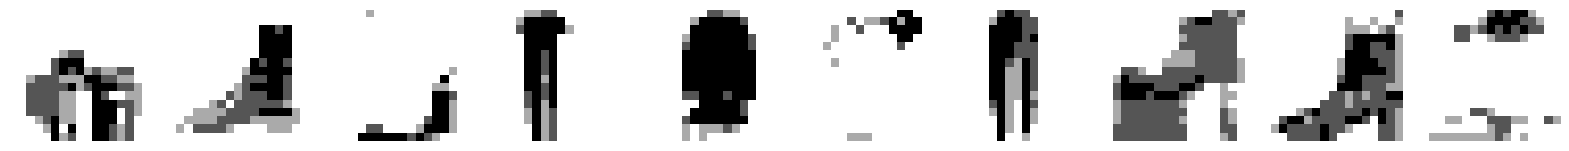

469/469 [==============================] - 24s 52ms/step - loss: 0.3416
Epoch 33/150
466/469 [============================>.] - ETA: 0s - loss: 0.3410
Saved to ./output/generated_img_032.png


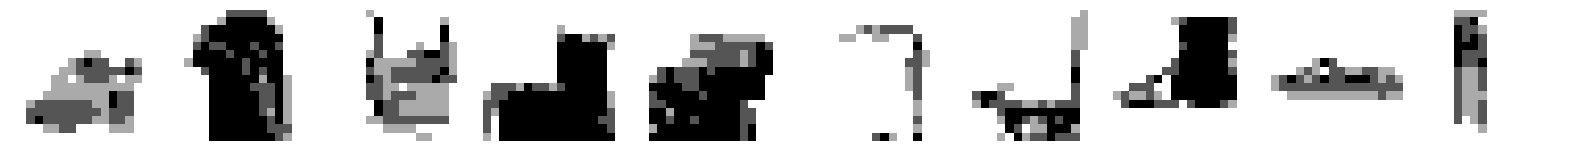

469/469 [==============================] - 26s 55ms/step - loss: 0.3410
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.3403
Saved to ./output/generated_img_033.png


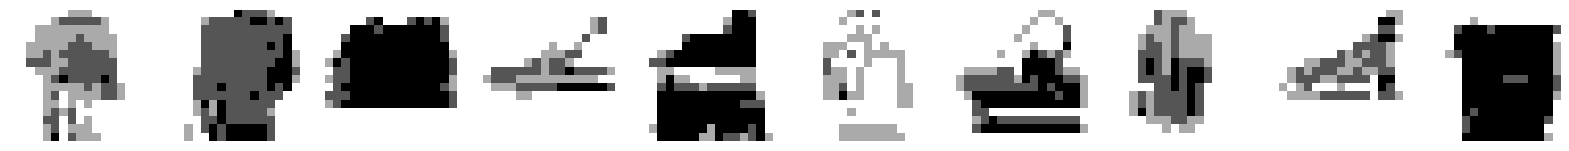

469/469 [==============================] - 26s 55ms/step - loss: 0.3403
Epoch 35/150
465/469 [============================>.] - ETA: 0s - loss: 0.3401
Saved to ./output/generated_img_034.png


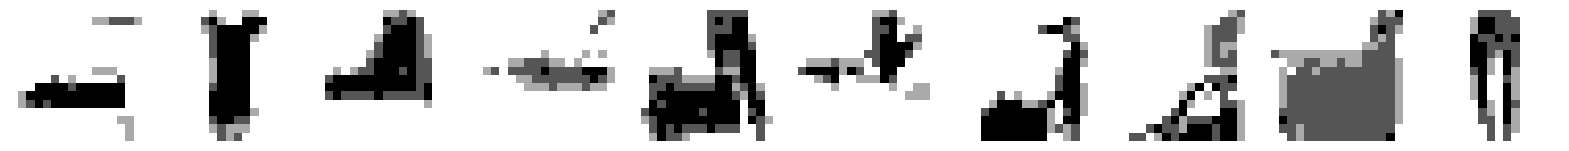

469/469 [==============================] - 25s 54ms/step - loss: 0.3401
Epoch 36/150
466/469 [============================>.] - ETA: 0s - loss: 0.3398
Saved to ./output/generated_img_035.png


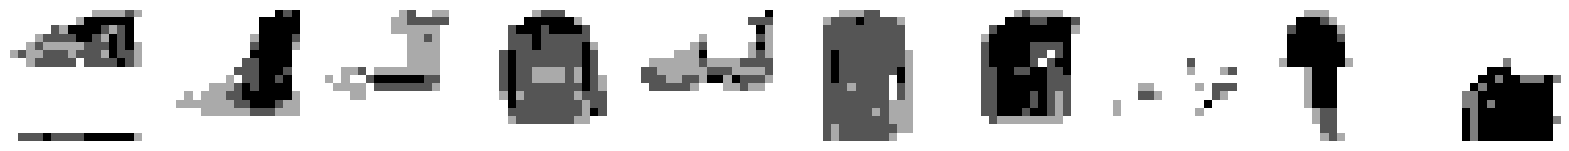

469/469 [==============================] - 26s 56ms/step - loss: 0.3399
Epoch 37/150
469/469 [==============================] - ETA: 0s - loss: 0.3396
Saved to ./output/generated_img_036.png


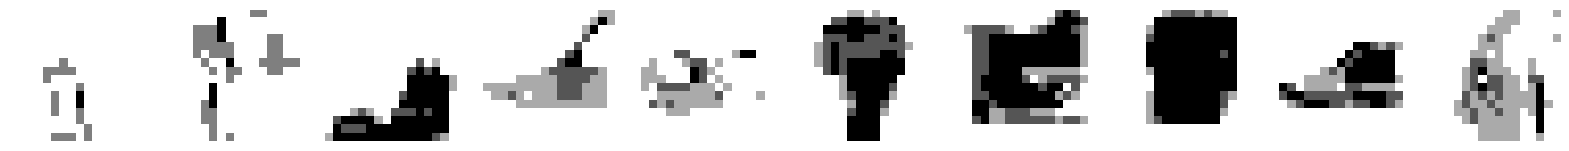

469/469 [==============================] - 25s 53ms/step - loss: 0.3396
Epoch 38/150
469/469 [==============================] - ETA: 0s - loss: 0.3389
Saved to ./output/generated_img_037.png


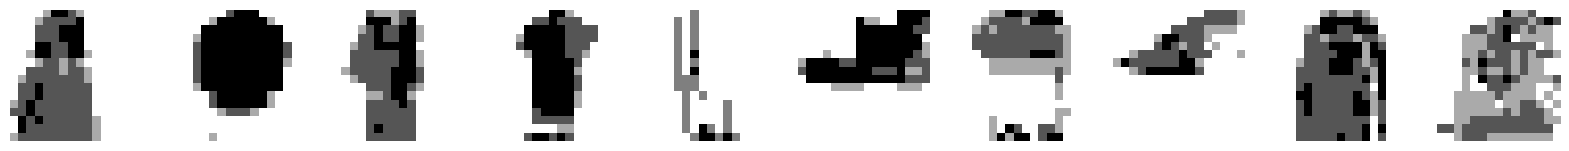

469/469 [==============================] - 26s 56ms/step - loss: 0.3389
Epoch 39/150
467/469 [============================>.] - ETA: 0s - loss: 0.3389
Saved to ./output/generated_img_038.png


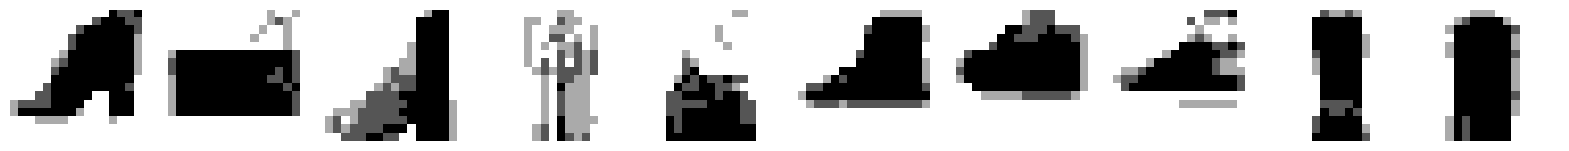

469/469 [==============================] - 25s 53ms/step - loss: 0.3389
Epoch 40/150
466/469 [============================>.] - ETA: 0s - loss: 0.3384
Saved to ./output/generated_img_039.png


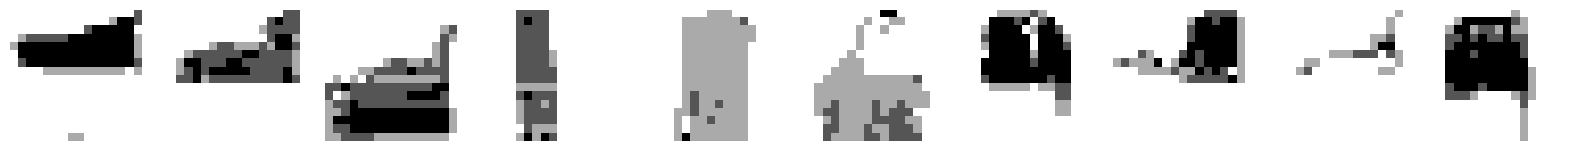

469/469 [==============================] - 25s 52ms/step - loss: 0.3385
Epoch 41/150
467/469 [============================>.] - ETA: 0s - loss: 0.3379
Saved to ./output/generated_img_040.png


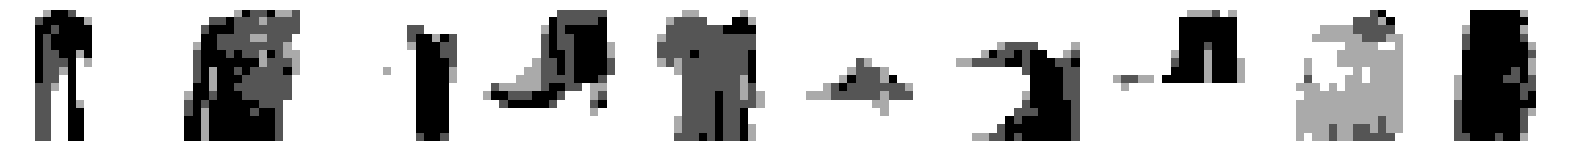

469/469 [==============================] - 27s 57ms/step - loss: 0.3379
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.3377
Saved to ./output/generated_img_041.png


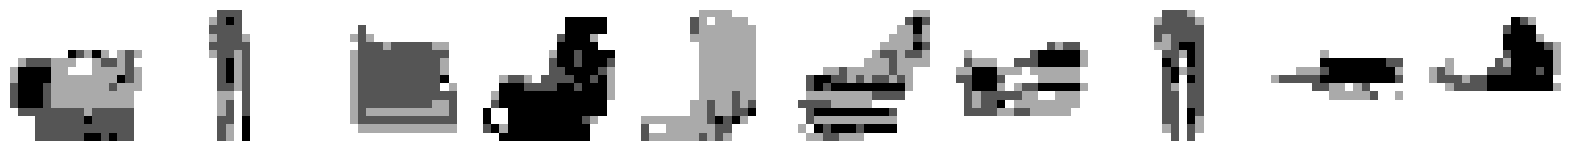

469/469 [==============================] - 25s 53ms/step - loss: 0.3377
Epoch 43/150
465/469 [============================>.] - ETA: 0s - loss: 0.3373
Saved to ./output/generated_img_042.png


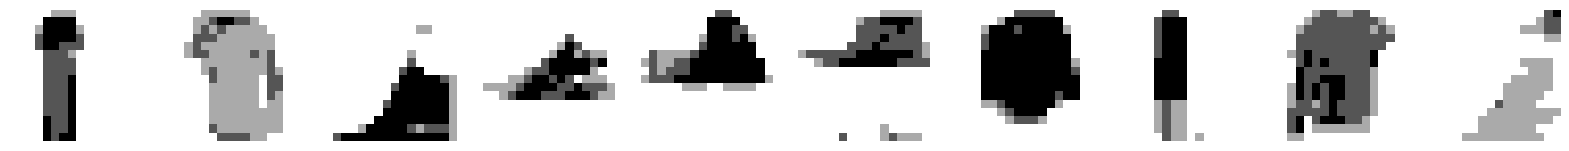

469/469 [==============================] - 26s 56ms/step - loss: 0.3374
Epoch 44/150
466/469 [============================>.] - ETA: 0s - loss: 0.3370
Saved to ./output/generated_img_043.png


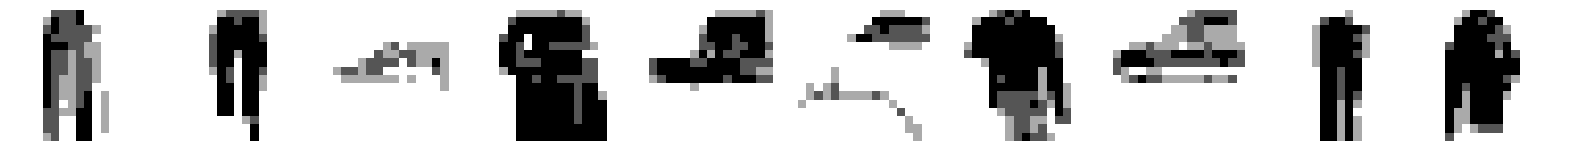

469/469 [==============================] - 26s 55ms/step - loss: 0.3370
Epoch 45/150
468/469 [============================>.] - ETA: 0s - loss: 0.3368
Saved to ./output/generated_img_044.png


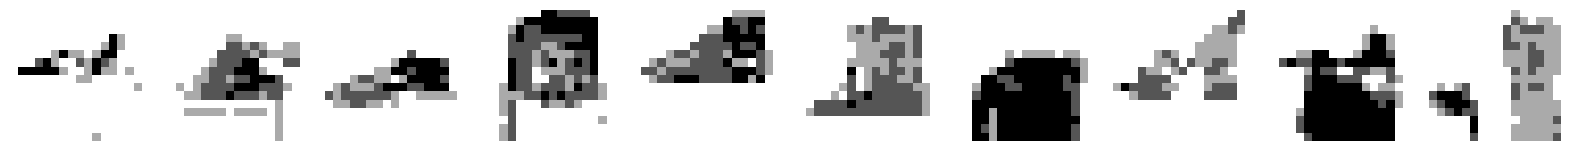

469/469 [==============================] - 25s 54ms/step - loss: 0.3368
Epoch 46/150
467/469 [============================>.] - ETA: 0s - loss: 0.3365
Saved to ./output/generated_img_045.png


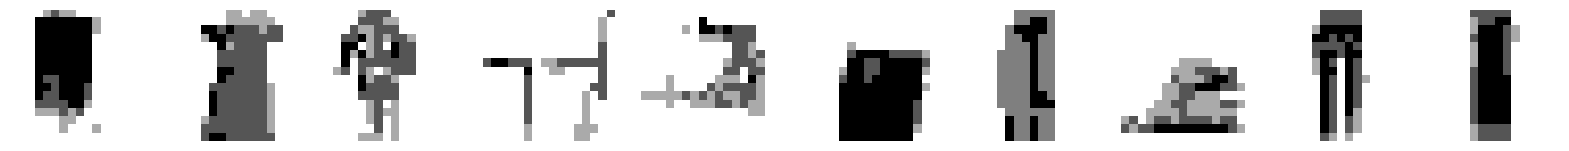

469/469 [==============================] - 27s 57ms/step - loss: 0.3365
Epoch 47/150
467/469 [============================>.] - ETA: 0s - loss: 0.3363
Saved to ./output/generated_img_046.png


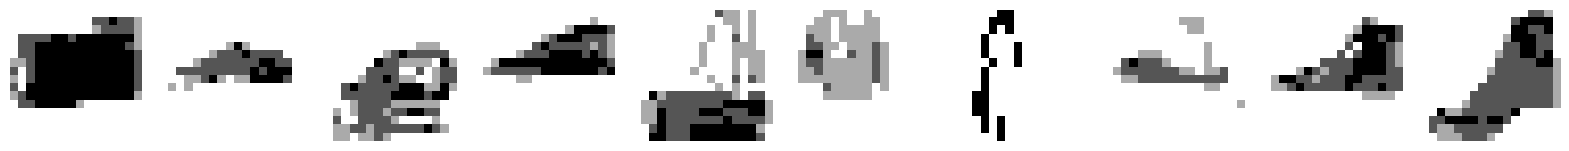

469/469 [==============================] - 25s 53ms/step - loss: 0.3364
Epoch 48/150
465/469 [============================>.] - ETA: 0s - loss: 0.3361
Saved to ./output/generated_img_047.png


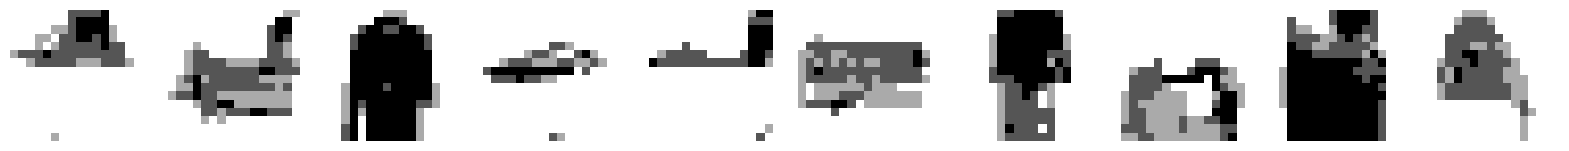

469/469 [==============================] - 27s 57ms/step - loss: 0.3361
Epoch 49/150
465/469 [============================>.] - ETA: 0s - loss: 0.3355
Saved to ./output/generated_img_048.png


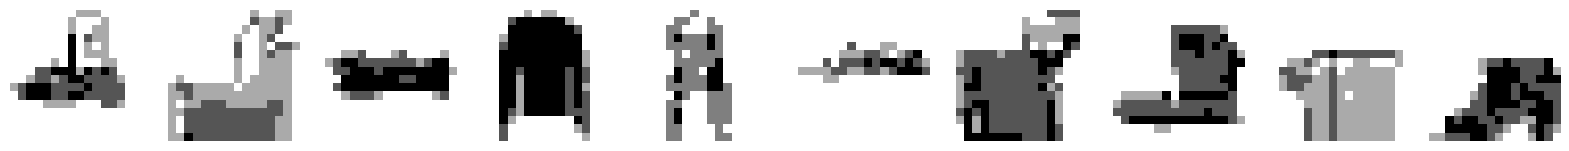

469/469 [==============================] - 25s 54ms/step - loss: 0.3356
Epoch 50/150
468/469 [============================>.] - ETA: 0s - loss: 0.3357
Saved to ./output/generated_img_049.png


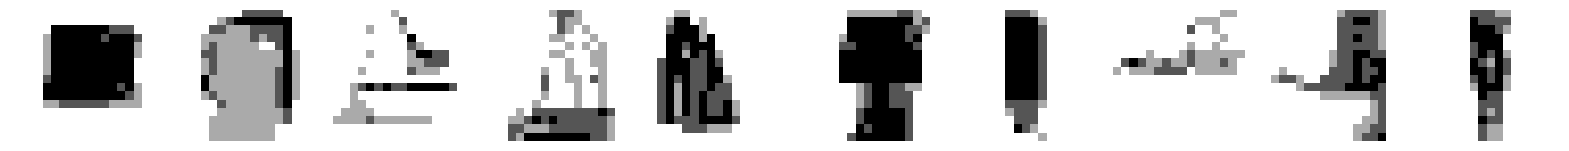

469/469 [==============================] - 25s 53ms/step - loss: 0.3357
Epoch 51/150
468/469 [============================>.] - ETA: 0s - loss: 0.3354
Saved to ./output/generated_img_050.png


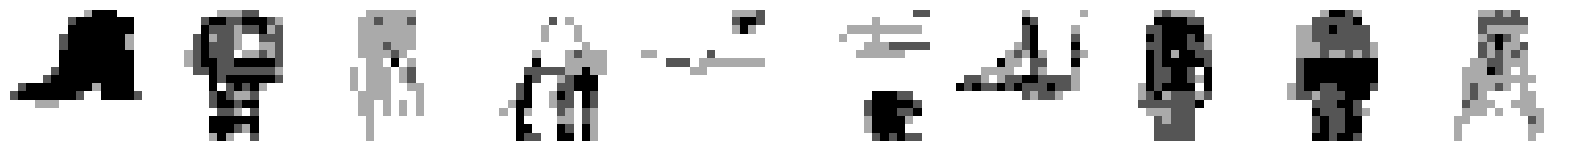

469/469 [==============================] - 27s 57ms/step - loss: 0.3354
Epoch 52/150
466/469 [============================>.] - ETA: 0s - loss: 0.3350
Saved to ./output/generated_img_051.png


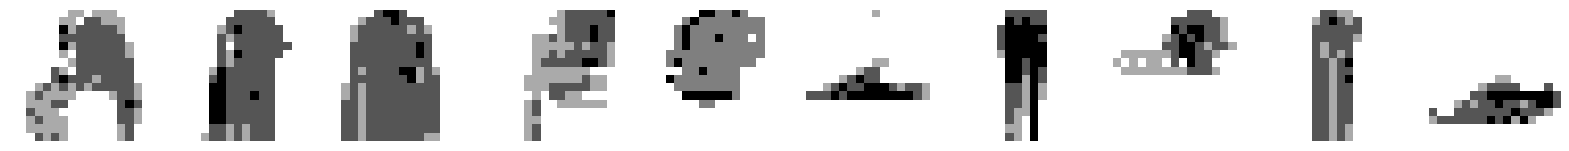

469/469 [==============================] - 25s 52ms/step - loss: 0.3350
Epoch 53/150
466/469 [============================>.] - ETA: 0s - loss: 0.3347
Saved to ./output/generated_img_052.png


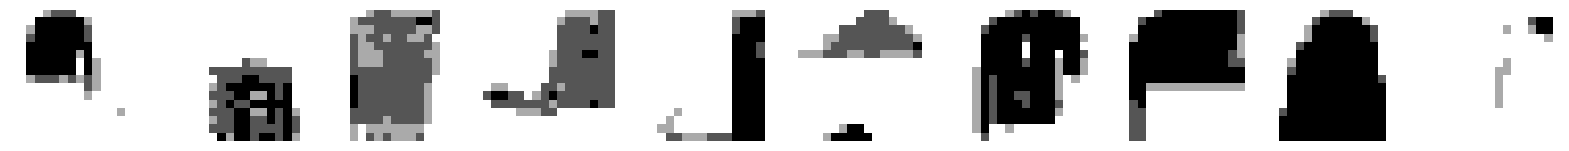

469/469 [==============================] - 27s 57ms/step - loss: 0.3347
Epoch 54/150
467/469 [============================>.] - ETA: 0s - loss: 0.3347
Saved to ./output/generated_img_053.png


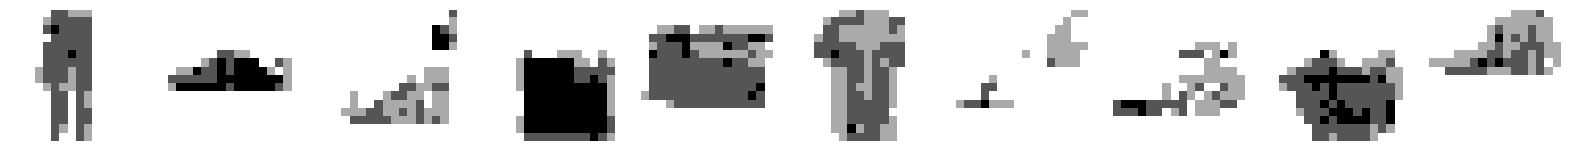

469/469 [==============================] - 25s 54ms/step - loss: 0.3346
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.3344
Saved to ./output/generated_img_054.png


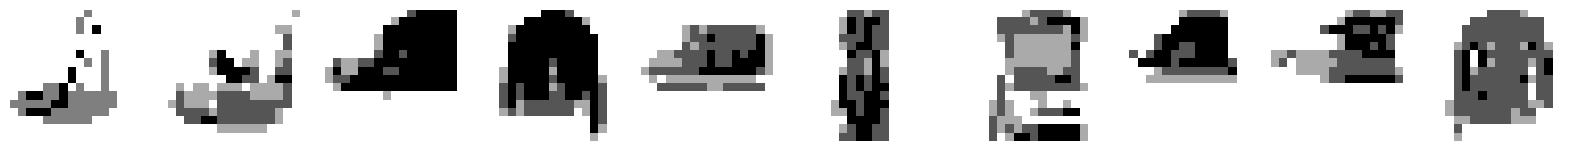

469/469 [==============================] - 25s 53ms/step - loss: 0.3344
Epoch 56/150
468/469 [============================>.] - ETA: 0s - loss: 0.3341
Saved to ./output/generated_img_055.png


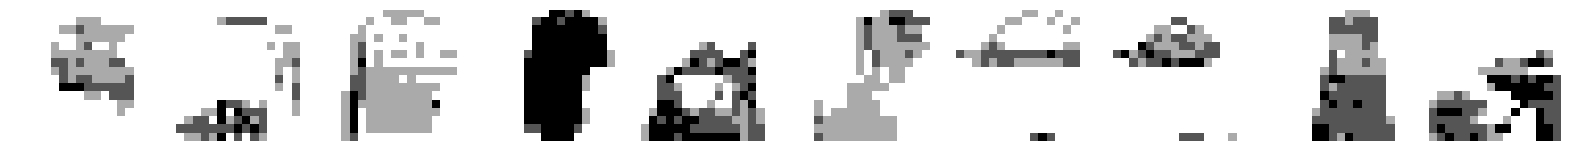

469/469 [==============================] - 27s 57ms/step - loss: 0.3341
Epoch 57/150
468/469 [============================>.] - ETA: 0s - loss: 0.3339
Saved to ./output/generated_img_056.png


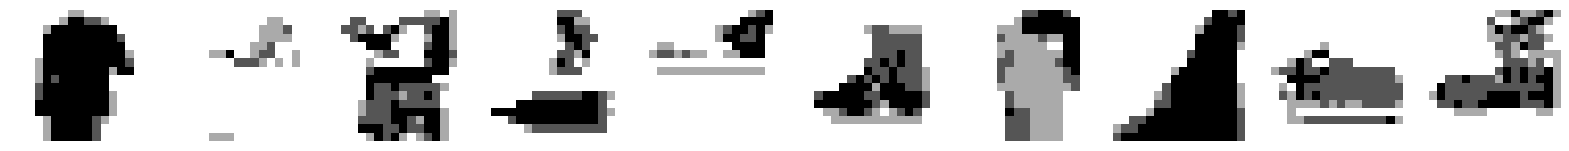

469/469 [==============================] - 25s 53ms/step - loss: 0.3339
Epoch 58/150
465/469 [============================>.] - ETA: 0s - loss: 0.3337
Saved to ./output/generated_img_057.png


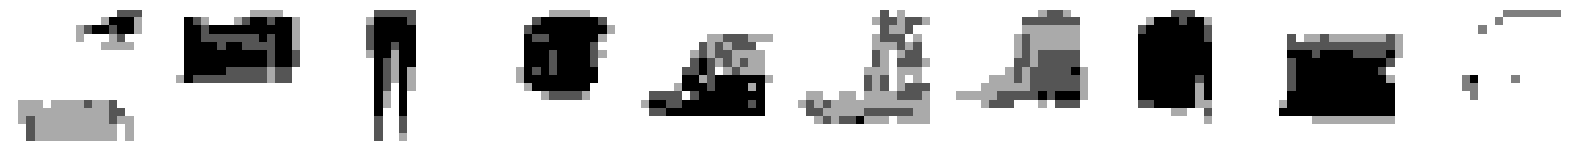

469/469 [==============================] - 27s 58ms/step - loss: 0.3337
Epoch 59/150
469/469 [==============================] - ETA: 0s - loss: 0.3335
Saved to ./output/generated_img_058.png


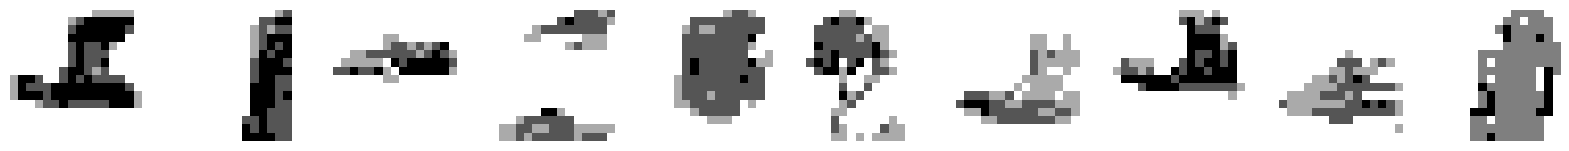

469/469 [==============================] - 25s 53ms/step - loss: 0.3335
Epoch 60/150
469/469 [==============================] - ETA: 0s - loss: 0.3333
Saved to ./output/generated_img_059.png


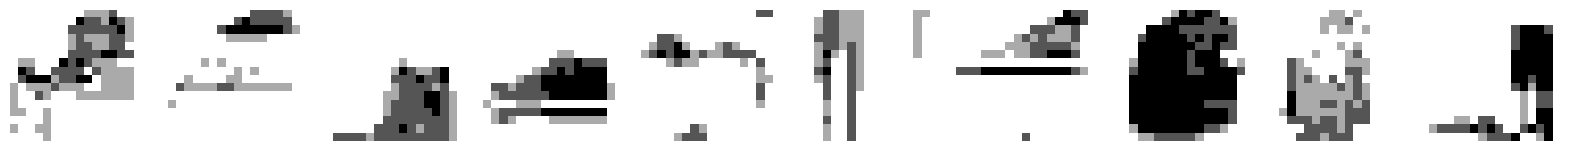

469/469 [==============================] - 25s 54ms/step - loss: 0.3333
Epoch 61/150
467/469 [============================>.] - ETA: 0s - loss: 0.3332
Saved to ./output/generated_img_060.png


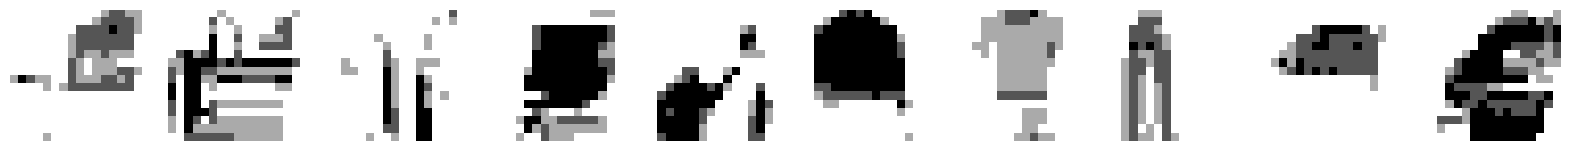

469/469 [==============================] - 26s 56ms/step - loss: 0.3331
Epoch 62/150
466/469 [============================>.] - ETA: 0s - loss: 0.3330
Saved to ./output/generated_img_061.png


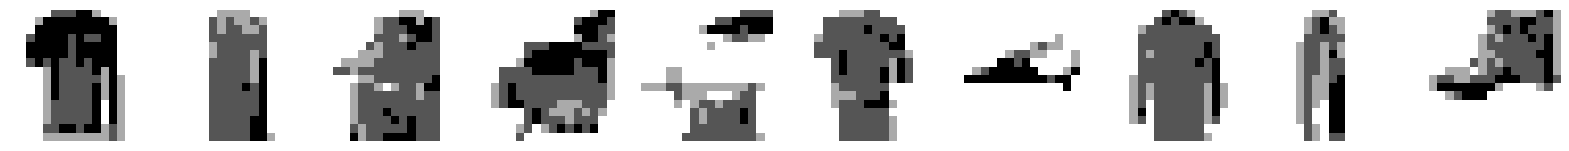

469/469 [==============================] - 25s 53ms/step - loss: 0.3330
Epoch 63/150
467/469 [============================>.] - ETA: 0s - loss: 0.3328
Saved to ./output/generated_img_062.png


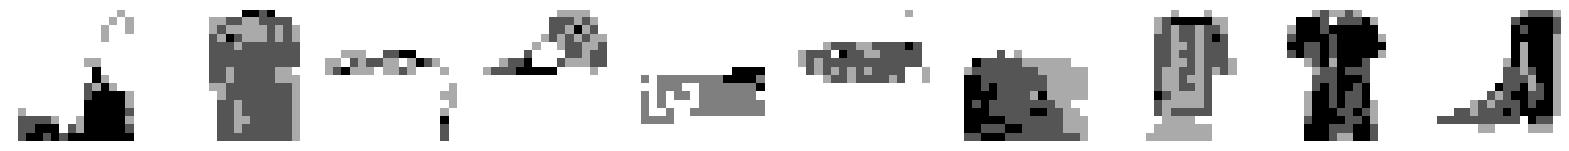

469/469 [==============================] - 27s 57ms/step - loss: 0.3327
Epoch 64/150
467/469 [============================>.] - ETA: 0s - loss: 0.3325
Saved to ./output/generated_img_063.png


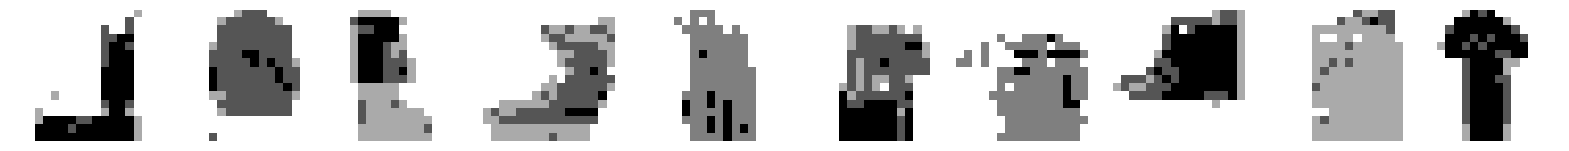

469/469 [==============================] - 25s 53ms/step - loss: 0.3325
Epoch 65/150
467/469 [============================>.] - ETA: 0s - loss: 0.3325
Saved to ./output/generated_img_064.png


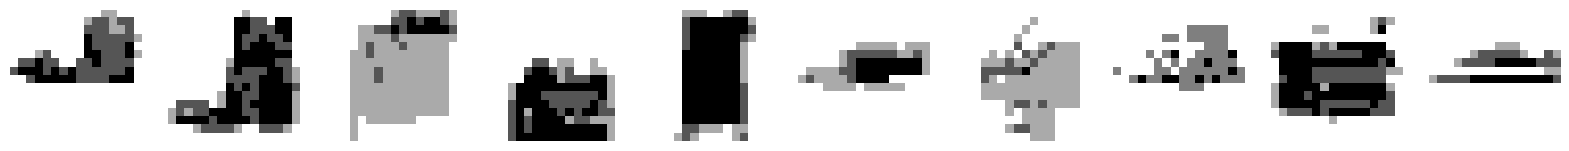

469/469 [==============================] - 25s 54ms/step - loss: 0.3325
Epoch 66/150
467/469 [============================>.] - ETA: 0s - loss: 0.3323
Saved to ./output/generated_img_065.png


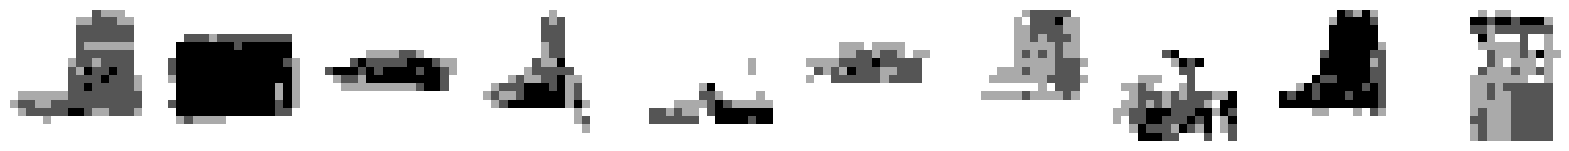

469/469 [==============================] - 26s 56ms/step - loss: 0.3323
Epoch 67/150
465/469 [============================>.] - ETA: 0s - loss: 0.3319
Saved to ./output/generated_img_066.png


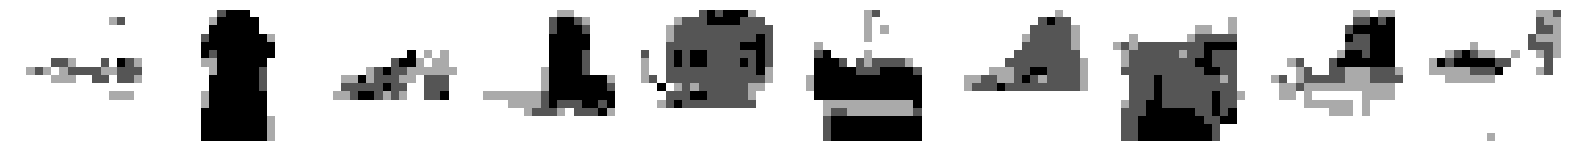

469/469 [==============================] - 25s 53ms/step - loss: 0.3320
Epoch 68/150
468/469 [============================>.] - ETA: 0s - loss: 0.3318
Saved to ./output/generated_img_067.png


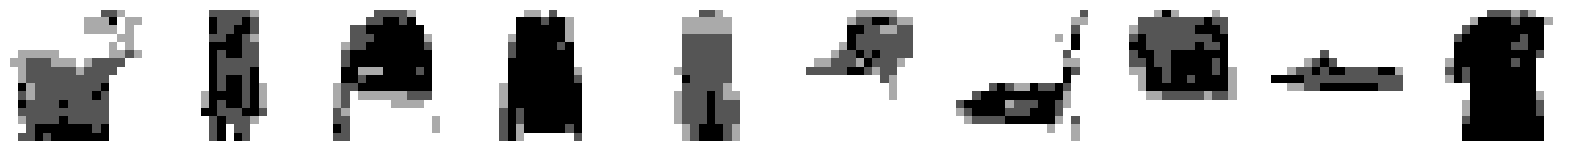

469/469 [==============================] - 27s 58ms/step - loss: 0.3318
Epoch 69/150
468/469 [============================>.] - ETA: 0s - loss: 0.3318
Saved to ./output/generated_img_068.png


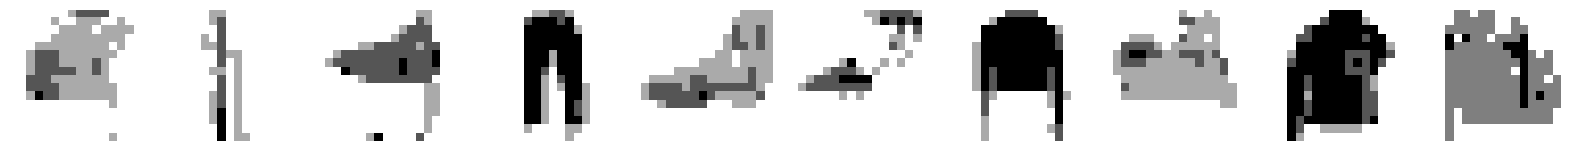

469/469 [==============================] - 25s 54ms/step - loss: 0.3318
Epoch 70/150
467/469 [============================>.] - ETA: 0s - loss: 0.3315
Saved to ./output/generated_img_069.png


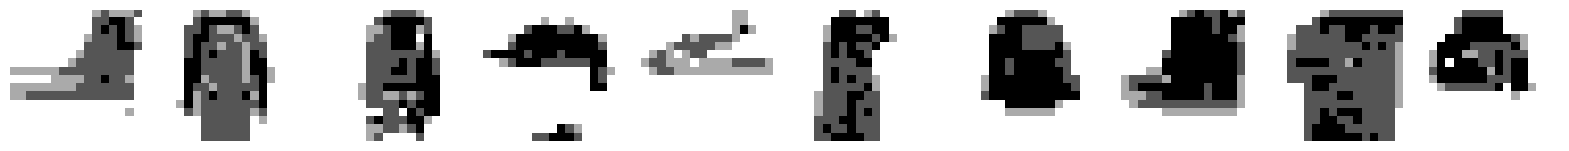

469/469 [==============================] - 26s 55ms/step - loss: 0.3315
Epoch 71/150
469/469 [==============================] - ETA: 0s - loss: 0.3314
Saved to ./output/generated_img_070.png


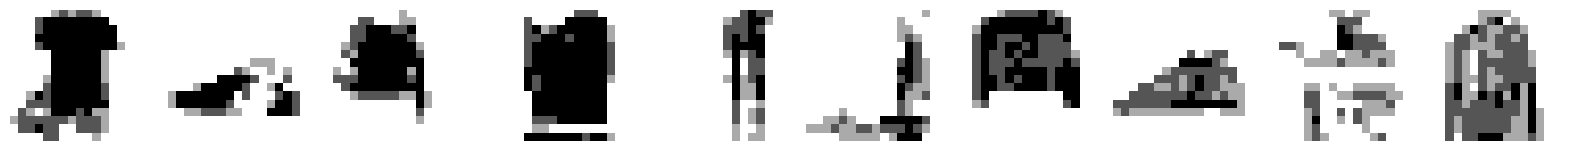

469/469 [==============================] - 26s 56ms/step - loss: 0.3314
Epoch 72/150
468/469 [============================>.] - ETA: 0s - loss: 0.3312
Saved to ./output/generated_img_071.png


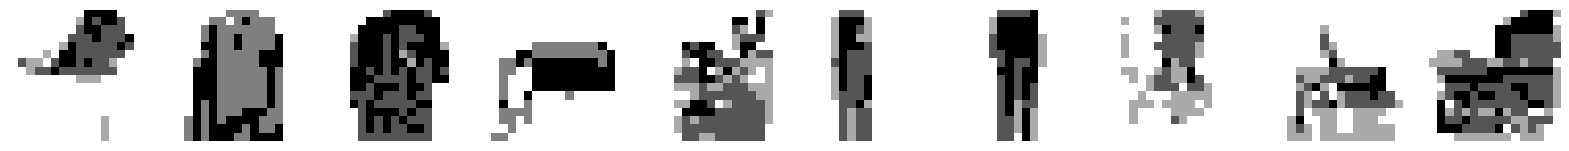

469/469 [==============================] - 25s 53ms/step - loss: 0.3313
Epoch 73/150
469/469 [==============================] - ETA: 0s - loss: 0.3311
Saved to ./output/generated_img_072.png


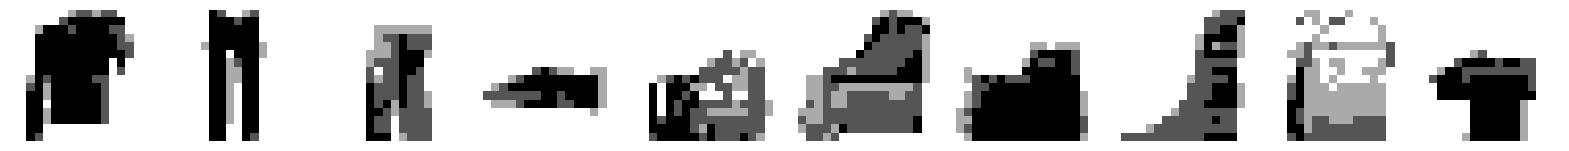

469/469 [==============================] - 27s 57ms/step - loss: 0.3311
Epoch 74/150
465/469 [============================>.] - ETA: 0s - loss: 0.3309
Saved to ./output/generated_img_073.png


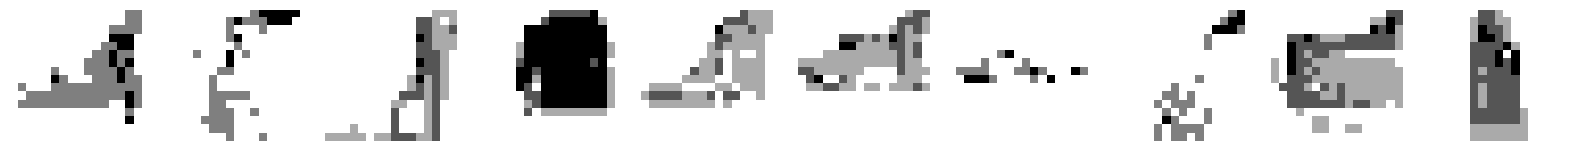

469/469 [==============================] - 25s 54ms/step - loss: 0.3310
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.3306
Saved to ./output/generated_img_074.png


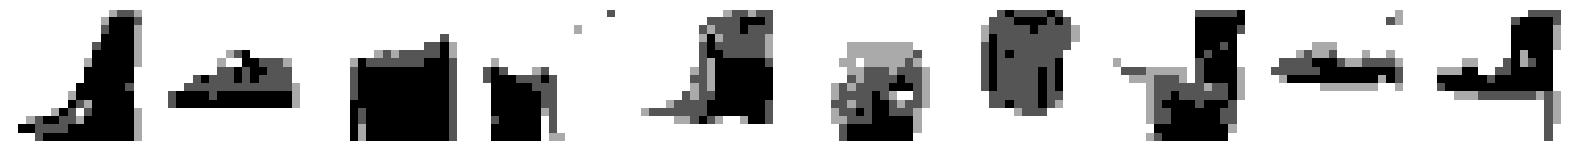

469/469 [==============================] - 26s 55ms/step - loss: 0.3306
Epoch 76/150
465/469 [============================>.] - ETA: 0s - loss: 0.3306
Saved to ./output/generated_img_075.png


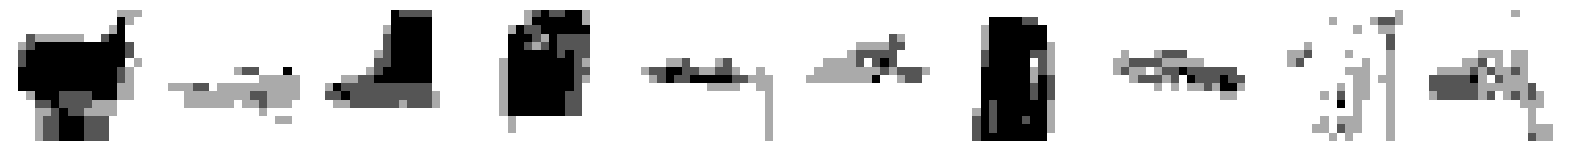

469/469 [==============================] - 26s 56ms/step - loss: 0.3306
Epoch 77/150
466/469 [============================>.] - ETA: 0s - loss: 0.3306
Saved to ./output/generated_img_076.png


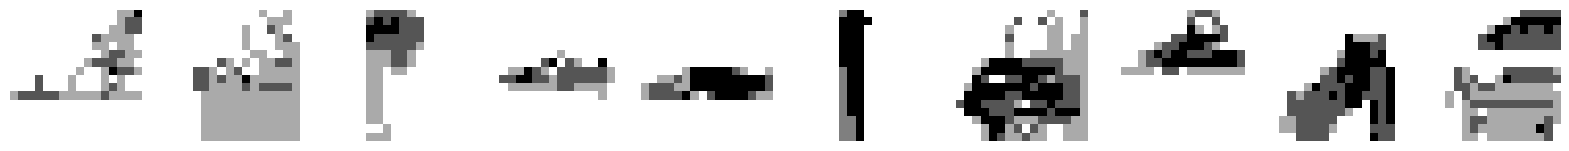

469/469 [==============================] - 25s 53ms/step - loss: 0.3306
Epoch 78/150
467/469 [============================>.] - ETA: 0s - loss: 0.3302
Saved to ./output/generated_img_077.png


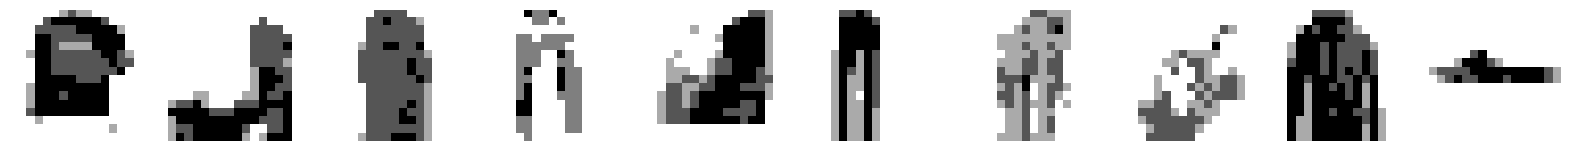

469/469 [==============================] - 27s 57ms/step - loss: 0.3302
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.3302
Saved to ./output/generated_img_078.png


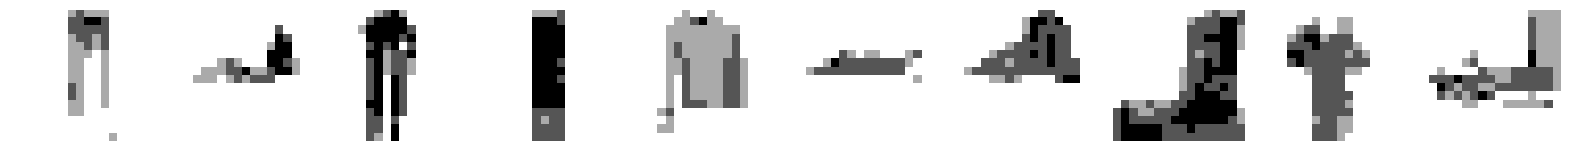

469/469 [==============================] - 25s 54ms/step - loss: 0.3302
Epoch 80/150
466/469 [============================>.] - ETA: 0s - loss: 0.3301
Saved to ./output/generated_img_079.png


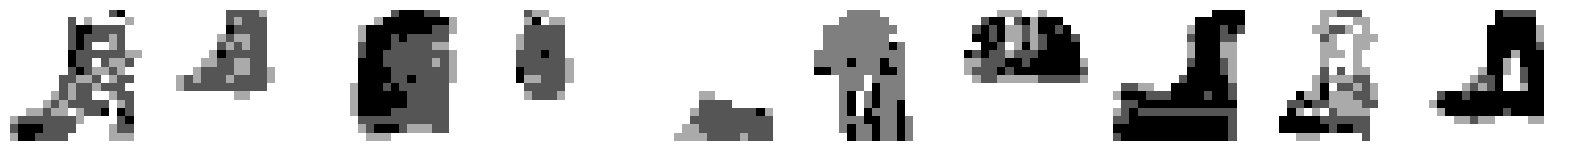

469/469 [==============================] - 25s 53ms/step - loss: 0.3301
Epoch 81/150
466/469 [============================>.] - ETA: 0s - loss: 0.3298
Saved to ./output/generated_img_080.png


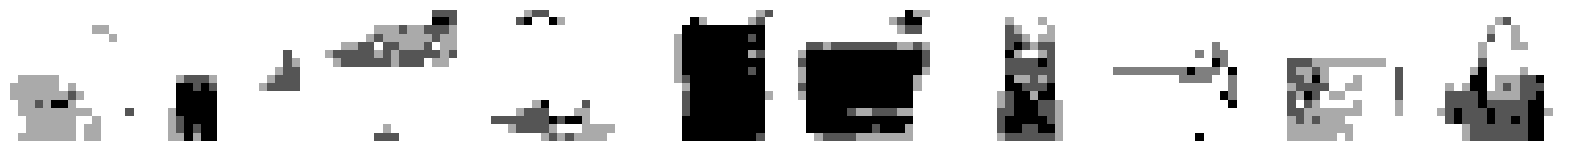

469/469 [==============================] - 27s 57ms/step - loss: 0.3298
Epoch 82/150
466/469 [============================>.] - ETA: 0s - loss: 0.3297
Saved to ./output/generated_img_081.png


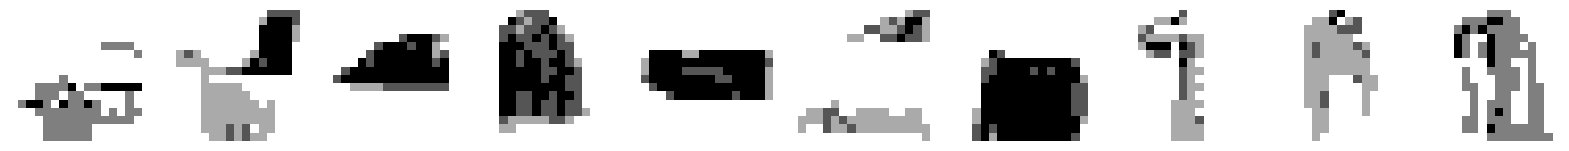

469/469 [==============================] - 25s 53ms/step - loss: 0.3297
Epoch 83/150
467/469 [============================>.] - ETA: 0s - loss: 0.3296
Saved to ./output/generated_img_082.png


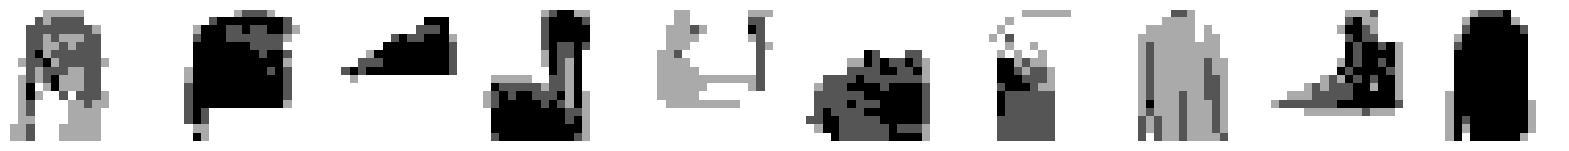

469/469 [==============================] - 27s 59ms/step - loss: 0.3296
Epoch 84/150
468/469 [============================>.] - ETA: 0s - loss: 0.3294
Saved to ./output/generated_img_083.png


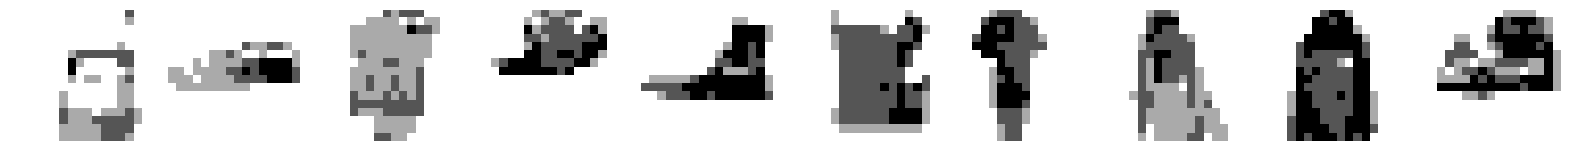

469/469 [==============================] - 25s 54ms/step - loss: 0.3294
Epoch 85/150
465/469 [============================>.] - ETA: 0s - loss: 0.3296
Saved to ./output/generated_img_084.png


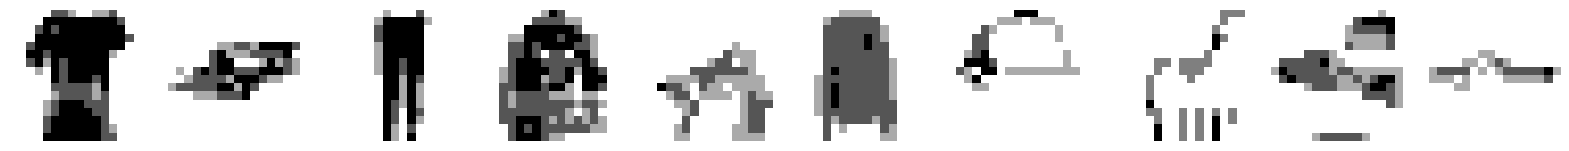

469/469 [==============================] - 25s 54ms/step - loss: 0.3295
Epoch 86/150
466/469 [============================>.] - ETA: 0s - loss: 0.3291
Saved to ./output/generated_img_085.png


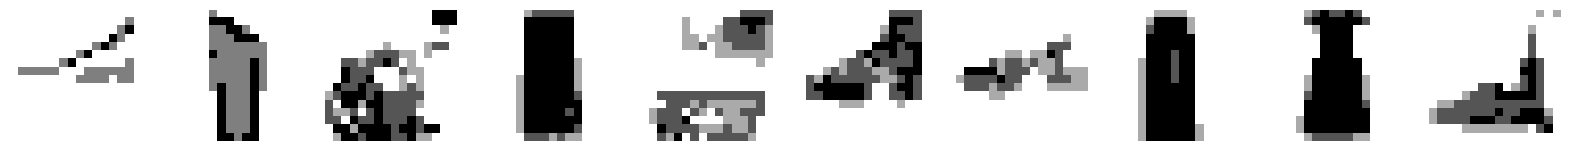

469/469 [==============================] - 27s 57ms/step - loss: 0.3291
Epoch 87/150
469/469 [==============================] - ETA: 0s - loss: 0.3290
Saved to ./output/generated_img_086.png


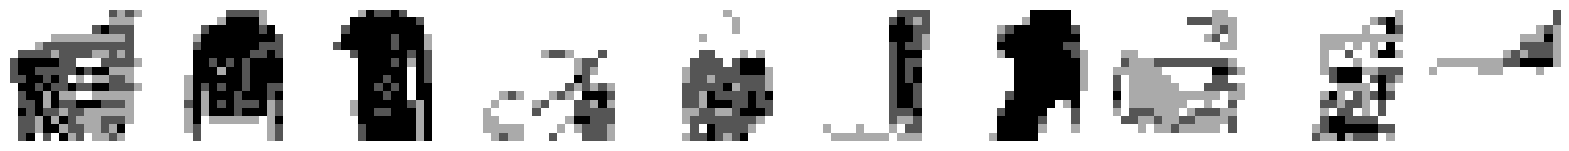

469/469 [==============================] - 25s 52ms/step - loss: 0.3290
Epoch 88/150
466/469 [============================>.] - ETA: 0s - loss: 0.3291
Saved to ./output/generated_img_087.png


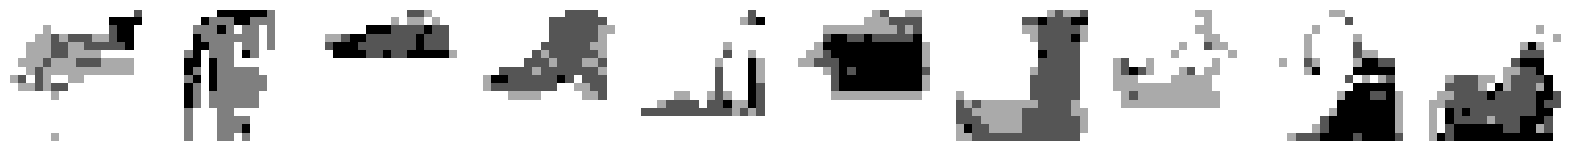

469/469 [==============================] - 27s 58ms/step - loss: 0.3291
Epoch 89/150
465/469 [============================>.] - ETA: 0s - loss: 0.3287
Saved to ./output/generated_img_088.png


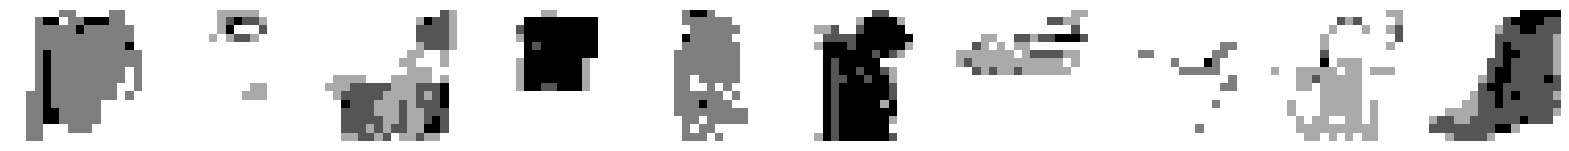

469/469 [==============================] - 25s 54ms/step - loss: 0.3288
Epoch 90/150
469/469 [==============================] - ETA: 0s - loss: 0.3288
Saved to ./output/generated_img_089.png


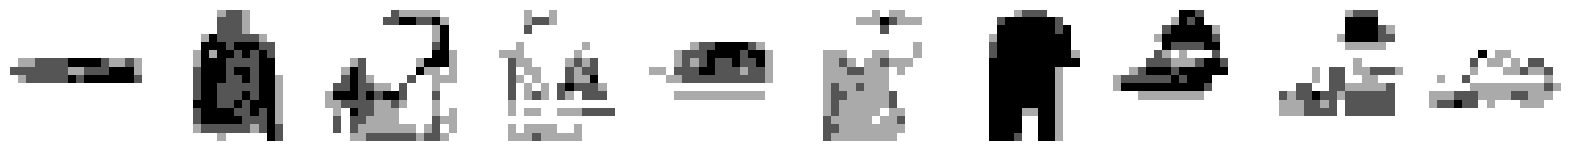

469/469 [==============================] - 25s 53ms/step - loss: 0.3288
Epoch 91/150
467/469 [============================>.] - ETA: 0s - loss: 0.3286
Saved to ./output/generated_img_090.png


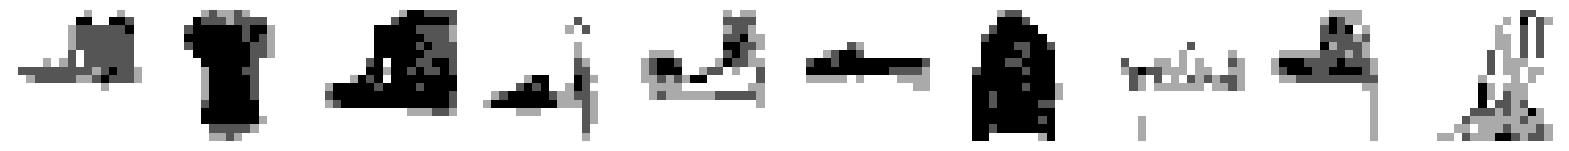

469/469 [==============================] - 27s 57ms/step - loss: 0.3285
Epoch 92/150
465/469 [============================>.] - ETA: 0s - loss: 0.3286
Saved to ./output/generated_img_091.png


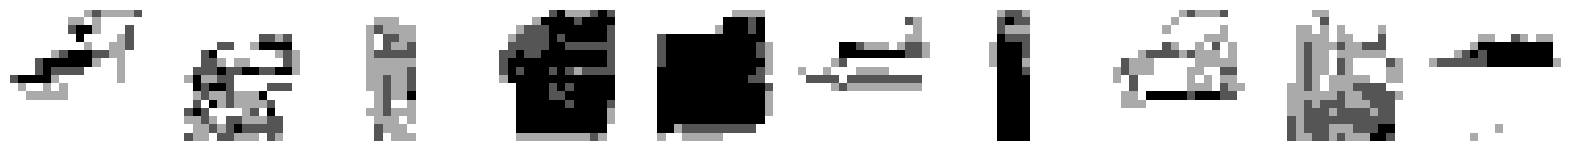

469/469 [==============================] - 25s 52ms/step - loss: 0.3286
Epoch 93/150
468/469 [============================>.] - ETA: 0s - loss: 0.3284
Saved to ./output/generated_img_092.png


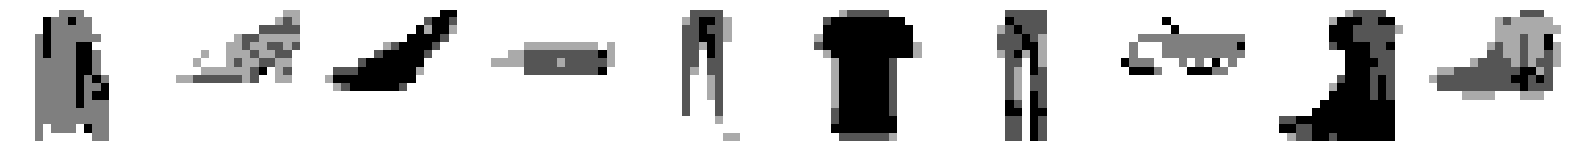

469/469 [==============================] - 28s 59ms/step - loss: 0.3284
Epoch 94/150
466/469 [============================>.] - ETA: 0s - loss: 0.3281
Saved to ./output/generated_img_093.png


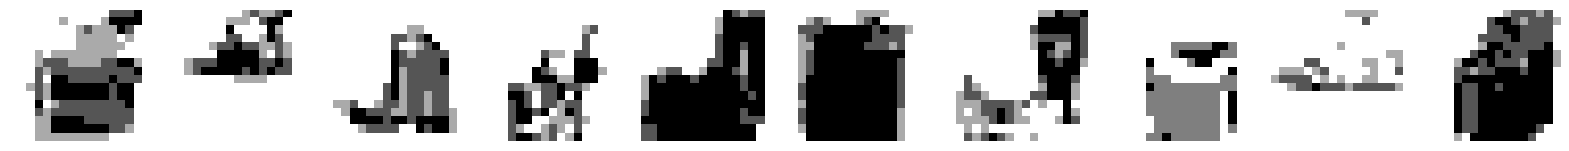

469/469 [==============================] - 25s 54ms/step - loss: 0.3281
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3282
Saved to ./output/generated_img_094.png


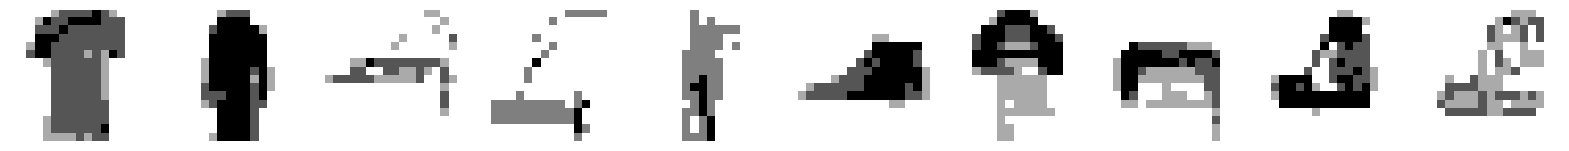

469/469 [==============================] - 25s 54ms/step - loss: 0.3282
Epoch 96/150
466/469 [============================>.] - ETA: 0s - loss: 0.3281
Saved to ./output/generated_img_095.png


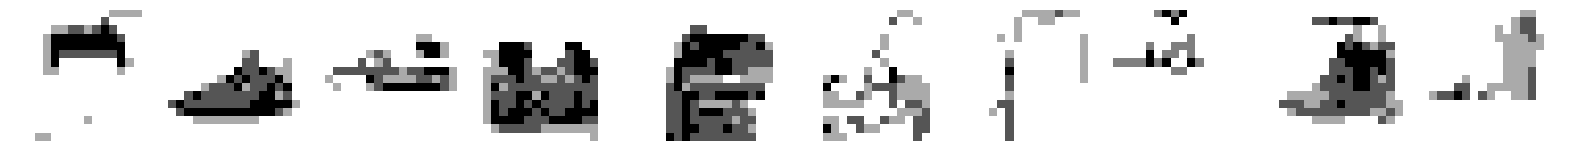

469/469 [==============================] - 27s 57ms/step - loss: 0.3282
Epoch 97/150
469/469 [==============================] - ETA: 0s - loss: 0.3279
Saved to ./output/generated_img_096.png


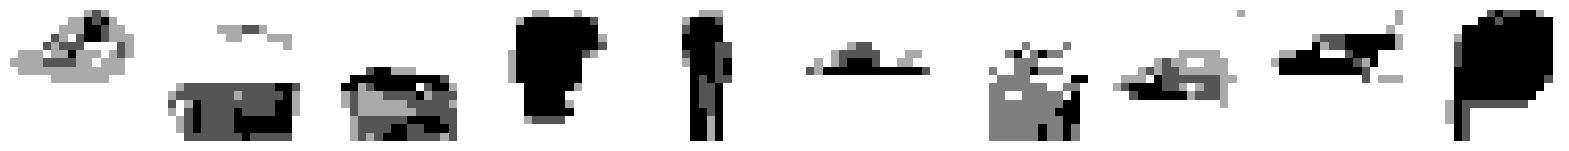

469/469 [==============================] - 25s 53ms/step - loss: 0.3279
Epoch 98/150
465/469 [============================>.] - ETA: 0s - loss: 0.3279
Saved to ./output/generated_img_097.png


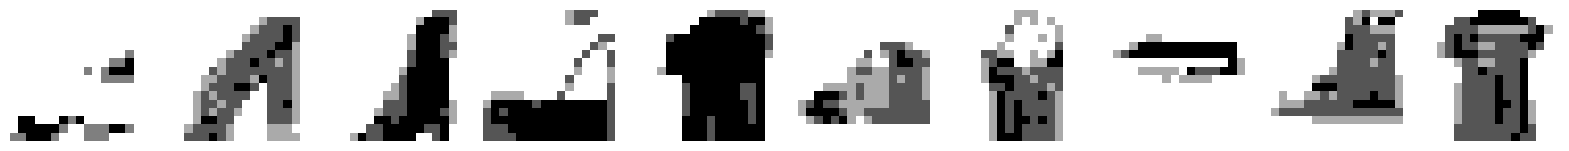

469/469 [==============================] - 28s 59ms/step - loss: 0.3279
Epoch 99/150
469/469 [==============================] - ETA: 0s - loss: 0.3277
Saved to ./output/generated_img_098.png


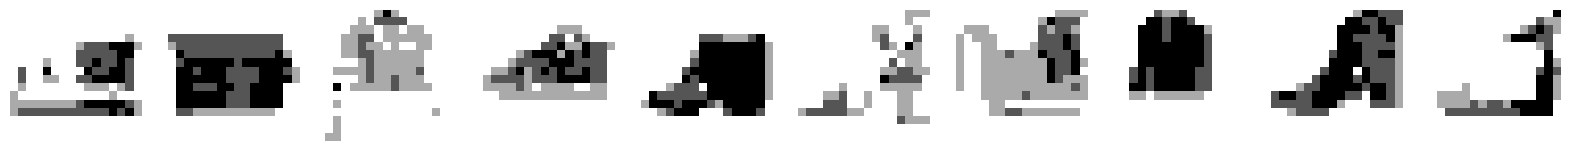

469/469 [==============================] - 25s 54ms/step - loss: 0.3277
Epoch 100/150
467/469 [============================>.] - ETA: 0s - loss: 0.3276
Saved to ./output/generated_img_099.png


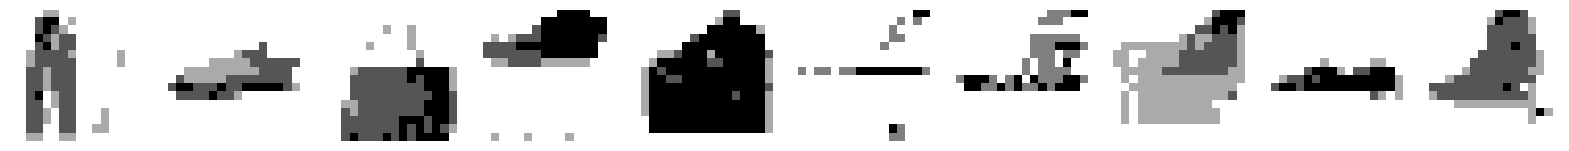

469/469 [==============================] - 25s 54ms/step - loss: 0.3276
Epoch 101/150
467/469 [============================>.] - ETA: 0s - loss: 0.3274
Saved to ./output/generated_img_100.png


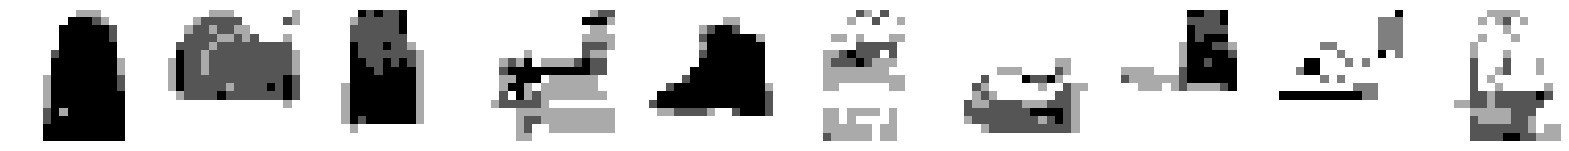

469/469 [==============================] - 27s 57ms/step - loss: 0.3274
Epoch 102/150
468/469 [============================>.] - ETA: 0s - loss: 0.3276
Saved to ./output/generated_img_101.png


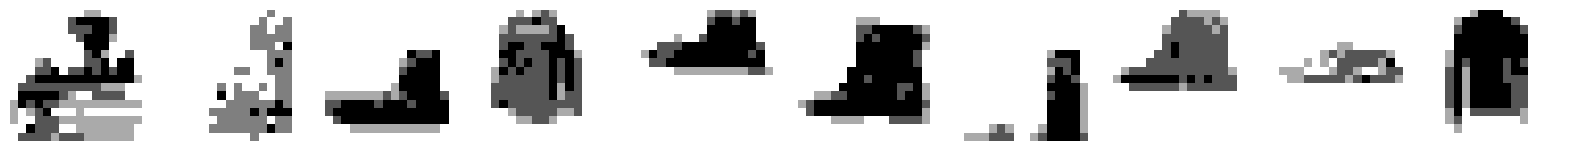

469/469 [==============================] - 25s 53ms/step - loss: 0.3276
Epoch 103/150
469/469 [==============================] - ETA: 0s - loss: 0.3274
Saved to ./output/generated_img_102.png


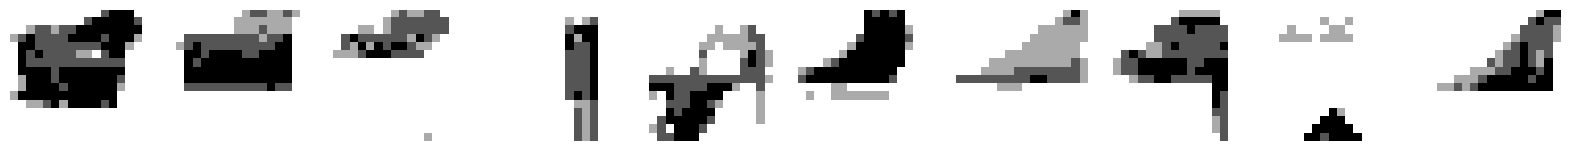

469/469 [==============================] - 27s 58ms/step - loss: 0.3274
Epoch 104/150
465/469 [============================>.] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_103.png


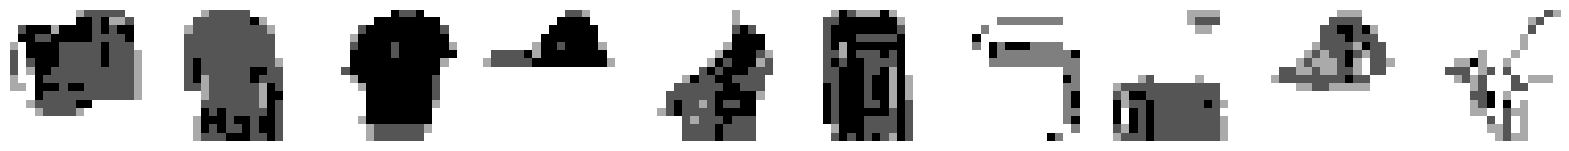

469/469 [==============================] - 25s 54ms/step - loss: 0.3271
Epoch 105/150
465/469 [============================>.] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_104.png


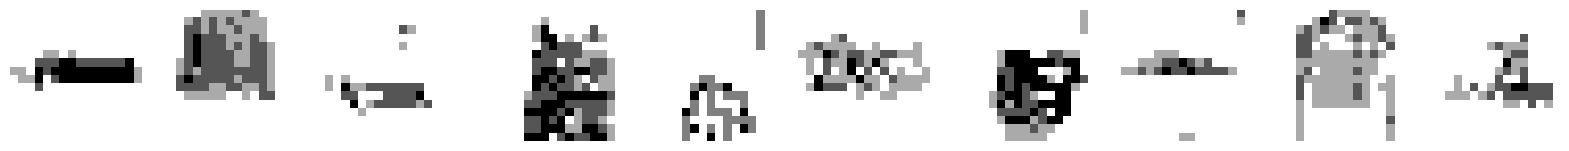

469/469 [==============================] - 25s 54ms/step - loss: 0.3272
Epoch 106/150
466/469 [============================>.] - ETA: 0s - loss: 0.3272
Saved to ./output/generated_img_105.png


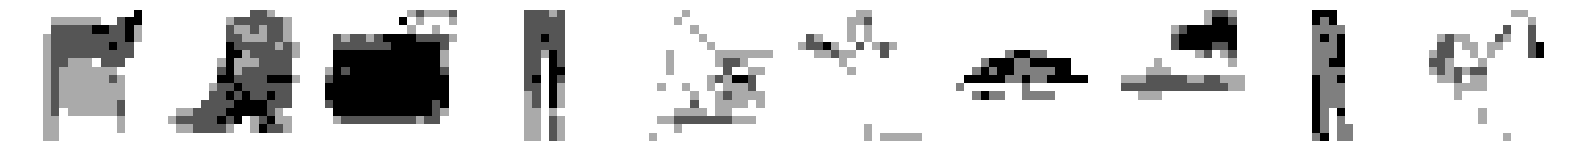

469/469 [==============================] - 27s 58ms/step - loss: 0.3272
Epoch 107/150
466/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to ./output/generated_img_106.png


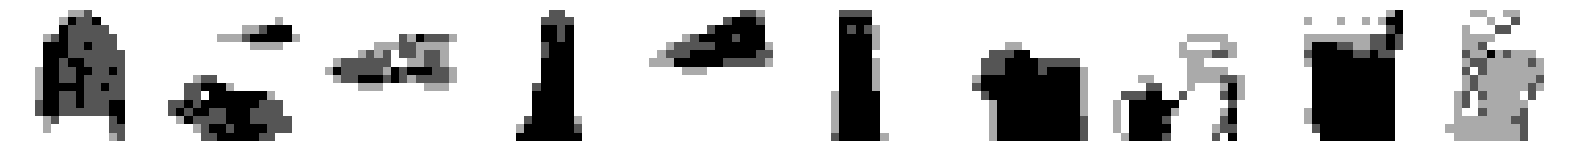

469/469 [==============================] - 25s 53ms/step - loss: 0.3269
Epoch 108/150
468/469 [============================>.] - ETA: 0s - loss: 0.3268
Saved to ./output/generated_img_107.png


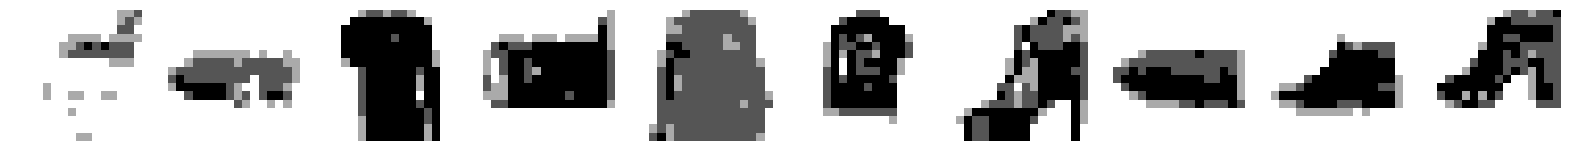

469/469 [==============================] - 28s 59ms/step - loss: 0.3268
Epoch 109/150
465/469 [============================>.] - ETA: 0s - loss: 0.3269
Saved to ./output/generated_img_108.png


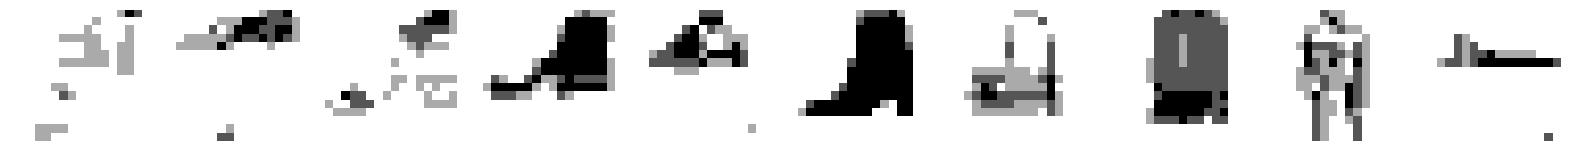

469/469 [==============================] - 25s 54ms/step - loss: 0.3268
Epoch 110/150
467/469 [============================>.] - ETA: 0s - loss: 0.3265
Saved to ./output/generated_img_109.png


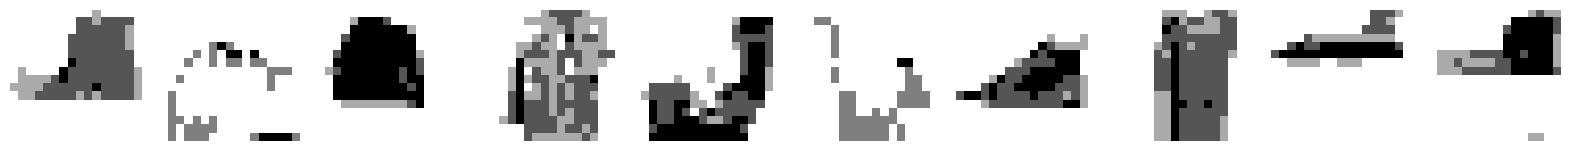

469/469 [==============================] - 25s 54ms/step - loss: 0.3265
Epoch 111/150
468/469 [============================>.] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_110.png


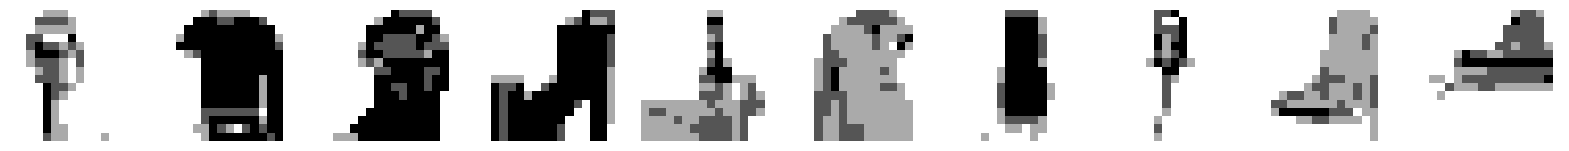

469/469 [==============================] - 27s 57ms/step - loss: 0.3266
Epoch 112/150
467/469 [============================>.] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_111.png


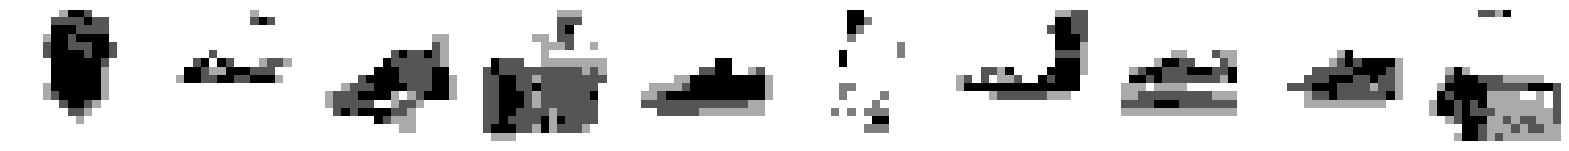

469/469 [==============================] - 25s 53ms/step - loss: 0.3266
Epoch 113/150
469/469 [==============================] - ETA: 0s - loss: 0.3266
Saved to ./output/generated_img_112.png


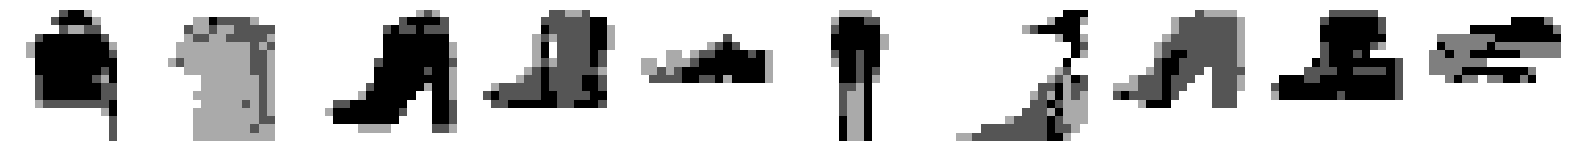

469/469 [==============================] - 27s 58ms/step - loss: 0.3266
Epoch 114/150
468/469 [============================>.] - ETA: 0s - loss: 0.3261
Saved to ./output/generated_img_113.png


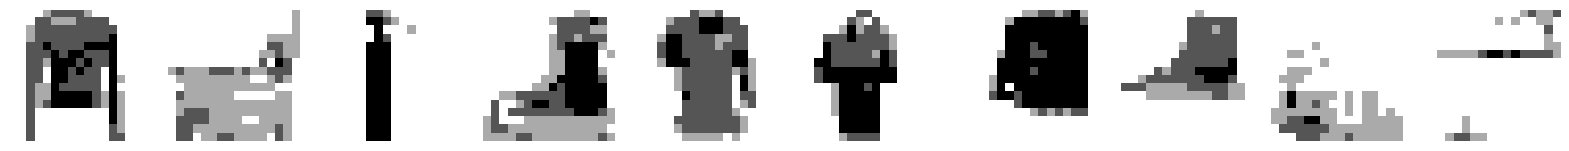

469/469 [==============================] - 25s 54ms/step - loss: 0.3261
Epoch 115/150
466/469 [============================>.] - ETA: 0s - loss: 0.3261
Saved to ./output/generated_img_114.png


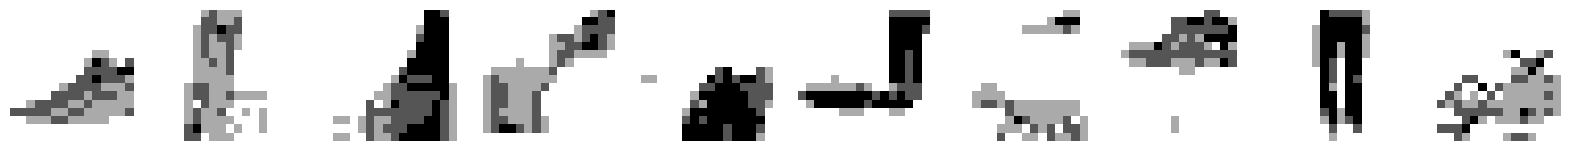

469/469 [==============================] - 25s 54ms/step - loss: 0.3261
Epoch 116/150
467/469 [============================>.] - ETA: 0s - loss: 0.3262
Saved to ./output/generated_img_115.png


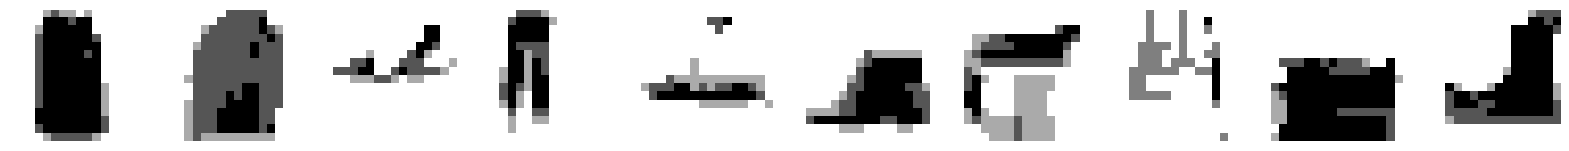

469/469 [==============================] - 27s 58ms/step - loss: 0.3261
Epoch 117/150
466/469 [============================>.] - ETA: 0s - loss: 0.3260
Saved to ./output/generated_img_116.png


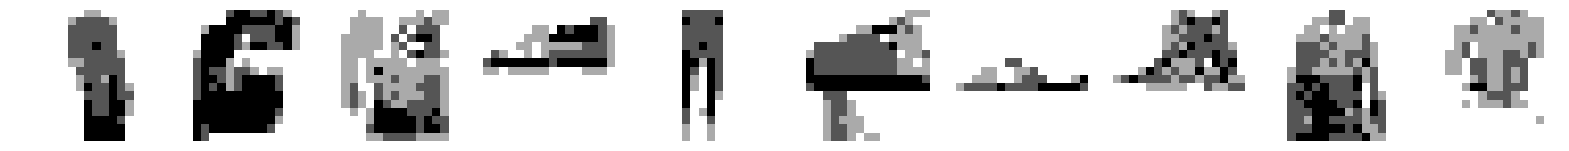

469/469 [==============================] - 25s 53ms/step - loss: 0.3261
Epoch 118/150
465/469 [============================>.] - ETA: 0s - loss: 0.3259
Saved to ./output/generated_img_117.png


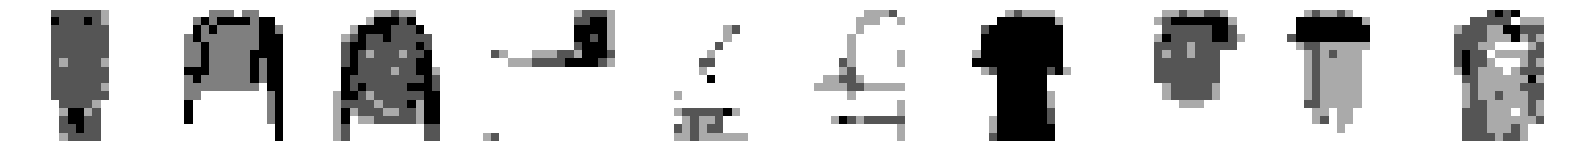

469/469 [==============================] - 27s 59ms/step - loss: 0.3260
Epoch 119/150
468/469 [============================>.] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_118.png


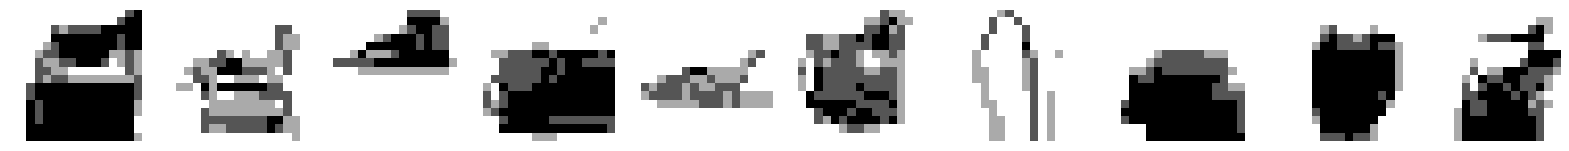

469/469 [==============================] - 25s 54ms/step - loss: 0.3259
Epoch 120/150
465/469 [============================>.] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_119.png


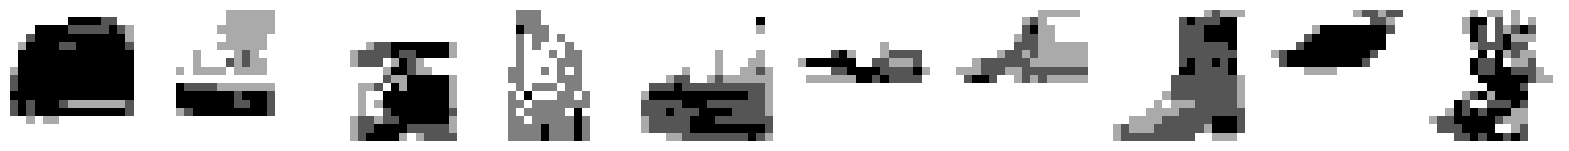

469/469 [==============================] - 25s 53ms/step - loss: 0.3257
Epoch 121/150
465/469 [============================>.] - ETA: 0s - loss: 0.3258
Saved to ./output/generated_img_120.png


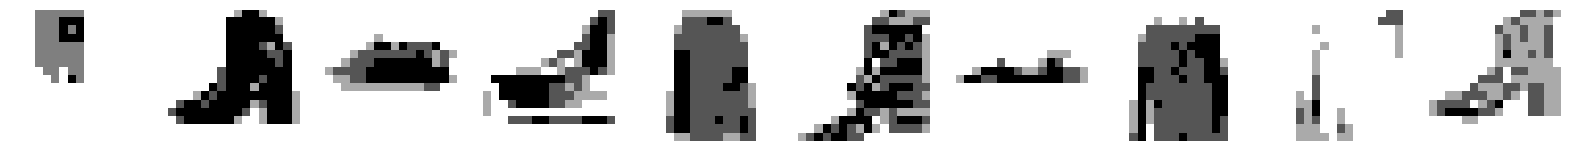

469/469 [==============================] - 27s 57ms/step - loss: 0.3258
Epoch 122/150
468/469 [============================>.] - ETA: 0s - loss: 0.3257
Saved to ./output/generated_img_121.png


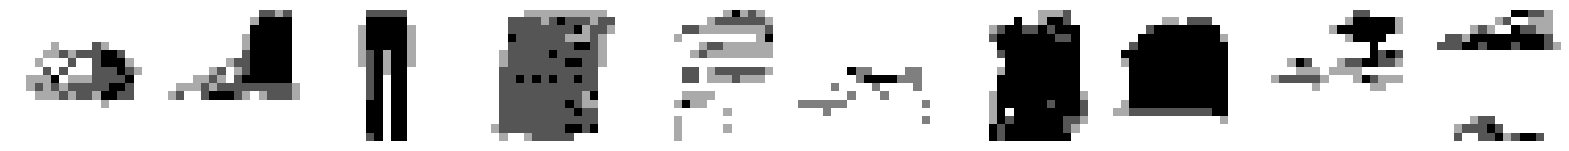

469/469 [==============================] - 25s 53ms/step - loss: 0.3257
Epoch 123/150
467/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to ./output/generated_img_122.png


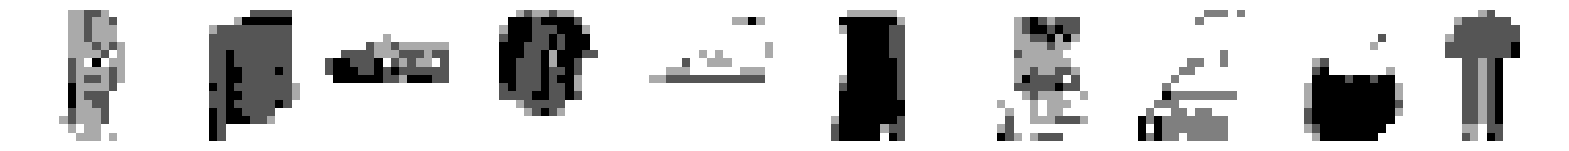

469/469 [==============================] - 28s 59ms/step - loss: 0.3255
Epoch 124/150
465/469 [============================>.] - ETA: 0s - loss: 0.3253
Saved to ./output/generated_img_123.png


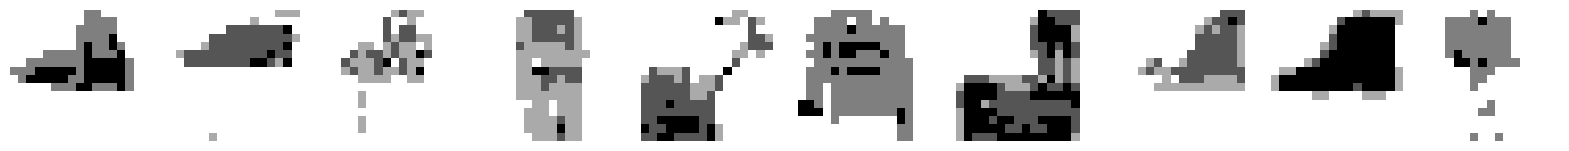

469/469 [==============================] - 25s 54ms/step - loss: 0.3254
Epoch 125/150
465/469 [============================>.] - ETA: 0s - loss: 0.3255
Saved to ./output/generated_img_124.png


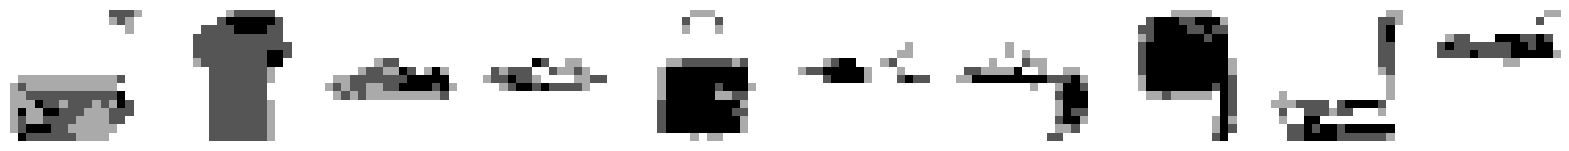

469/469 [==============================] - 25s 53ms/step - loss: 0.3255
Epoch 126/150
468/469 [============================>.] - ETA: 0s - loss: 0.3255
Saved to ./output/generated_img_125.png


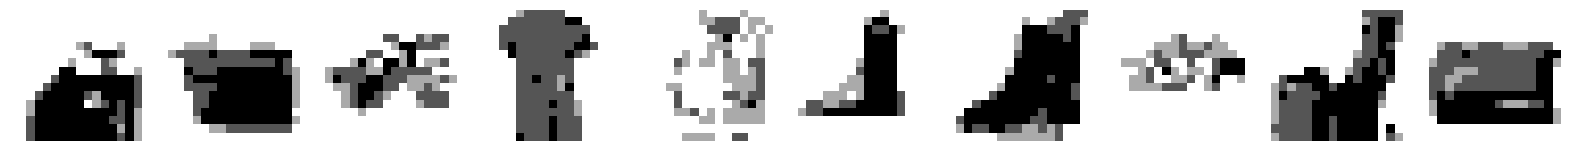

469/469 [==============================] - 27s 58ms/step - loss: 0.3255
Epoch 127/150
465/469 [============================>.] - ETA: 0s - loss: 0.3252
Saved to ./output/generated_img_126.png


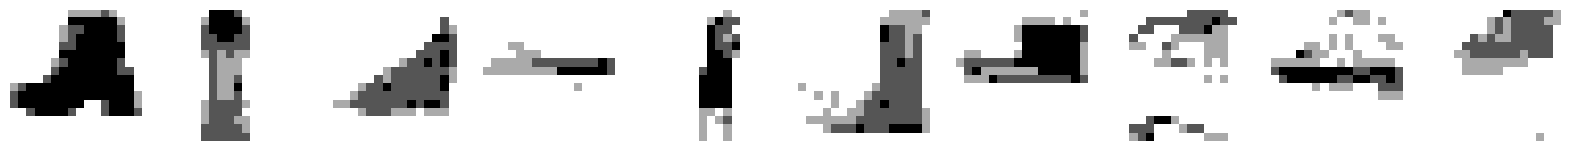

469/469 [==============================] - 25s 53ms/step - loss: 0.3252
Epoch 128/150
467/469 [============================>.] - ETA: 0s - loss: 0.3251
Saved to ./output/generated_img_127.png


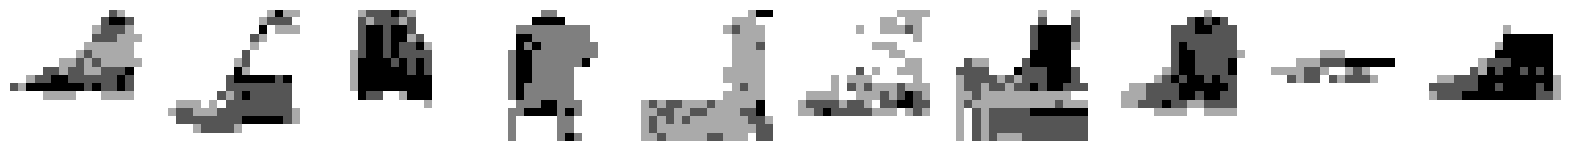

469/469 [==============================] - 28s 59ms/step - loss: 0.3251
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.3251
Saved to ./output/generated_img_128.png


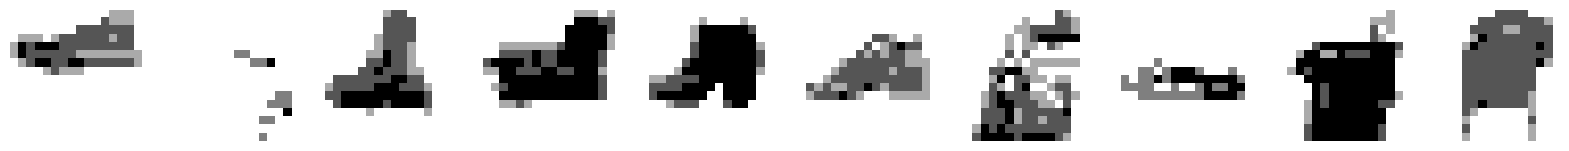

469/469 [==============================] - 25s 54ms/step - loss: 0.3251
Epoch 130/150
469/469 [==============================] - ETA: 0s - loss: 0.3251
Saved to ./output/generated_img_129.png


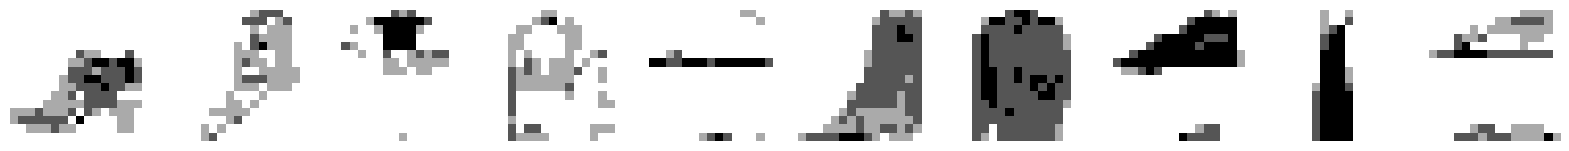

469/469 [==============================] - 25s 54ms/step - loss: 0.3251
Epoch 131/150
467/469 [============================>.] - ETA: 0s - loss: 0.3249
Saved to ./output/generated_img_130.png


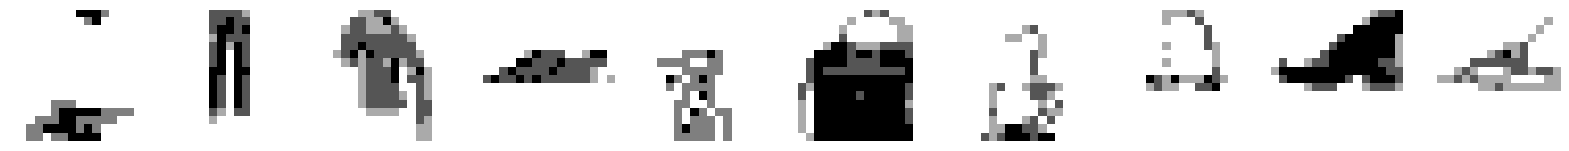

469/469 [==============================] - 27s 58ms/step - loss: 0.3250
Epoch 132/150
465/469 [============================>.] - ETA: 0s - loss: 0.3250
Saved to ./output/generated_img_131.png


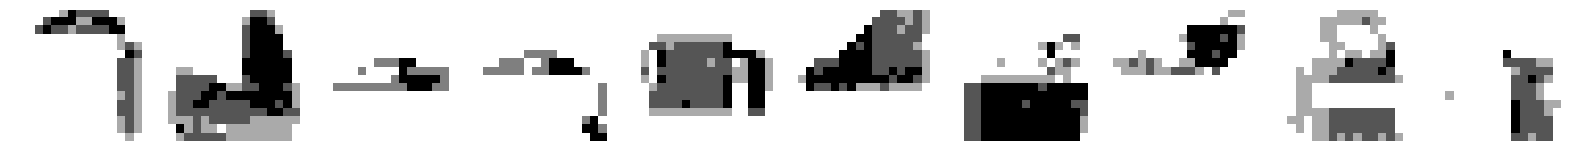

469/469 [==============================] - 25s 53ms/step - loss: 0.3249
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3250
Saved to ./output/generated_img_132.png


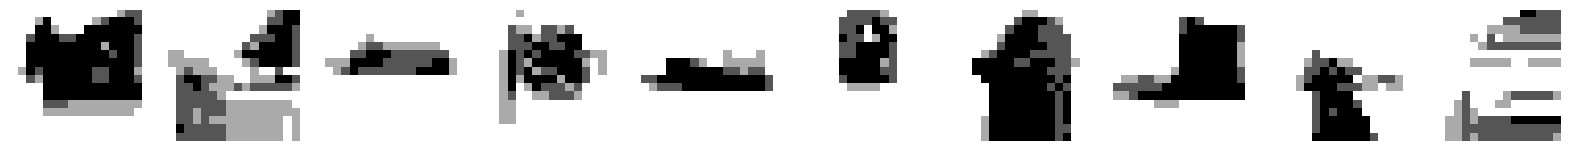

469/469 [==============================] - 28s 60ms/step - loss: 0.3250
Epoch 134/150
466/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_133.png


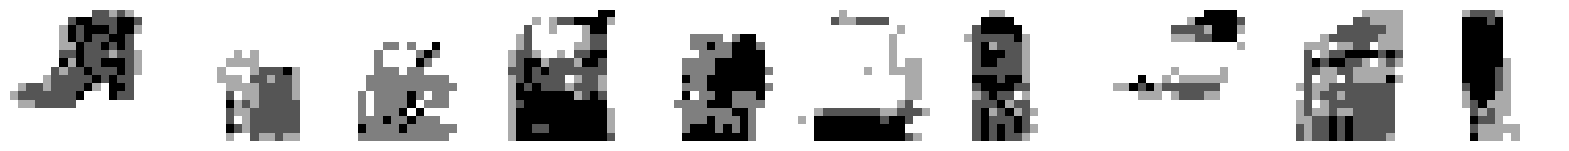

469/469 [==============================] - 26s 55ms/step - loss: 0.3246
Epoch 135/150
465/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_134.png


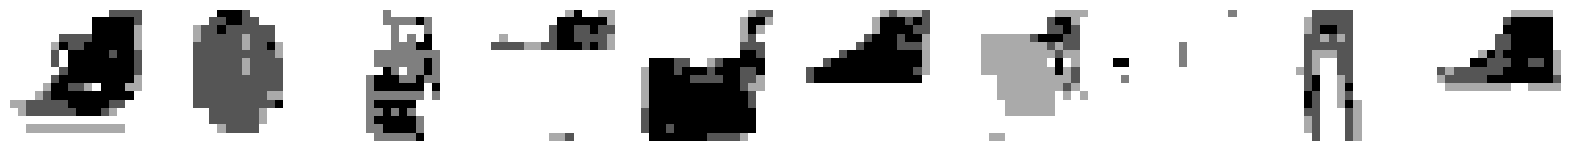

469/469 [==============================] - 25s 54ms/step - loss: 0.3245
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.3246
Saved to ./output/generated_img_135.png


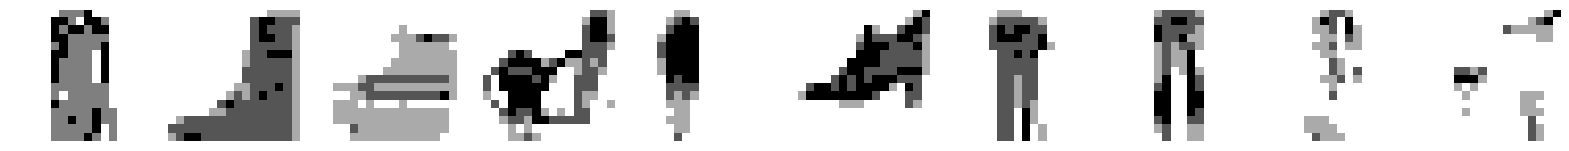

469/469 [==============================] - 27s 59ms/step - loss: 0.3246
Epoch 137/150
466/469 [============================>.] - ETA: 0s - loss: 0.3248
Saved to ./output/generated_img_136.png


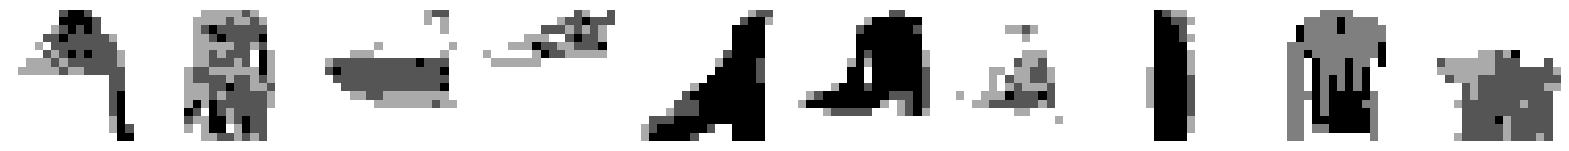

469/469 [==============================] - 25s 54ms/step - loss: 0.3248
Epoch 138/150
465/469 [============================>.] - ETA: 0s - loss: 0.3245
Saved to ./output/generated_img_137.png


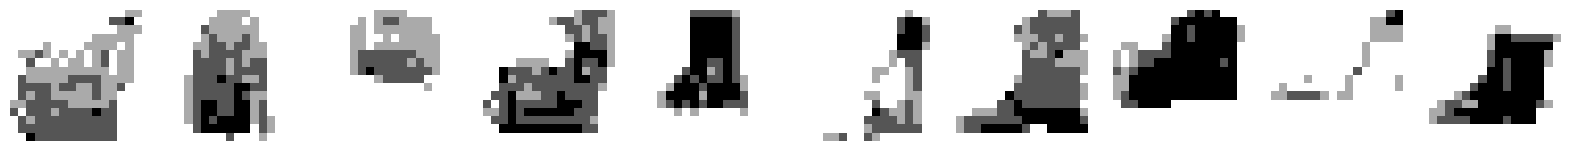

469/469 [==============================] - 28s 59ms/step - loss: 0.3244
Epoch 139/150
465/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to ./output/generated_img_138.png


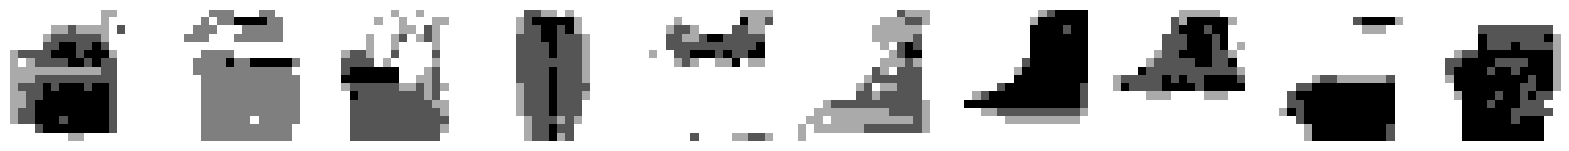

469/469 [==============================] - 26s 55ms/step - loss: 0.3245
Epoch 140/150
466/469 [============================>.] - ETA: 0s - loss: 0.3244
Saved to ./output/generated_img_139.png


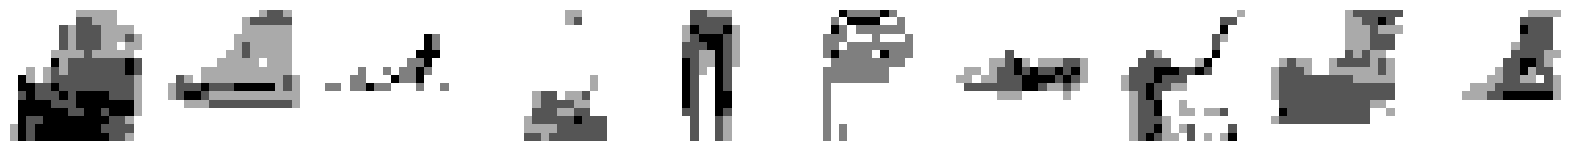

469/469 [==============================] - 26s 55ms/step - loss: 0.3243
Epoch 141/150
466/469 [============================>.] - ETA: 0s - loss: 0.3242
Saved to ./output/generated_img_140.png


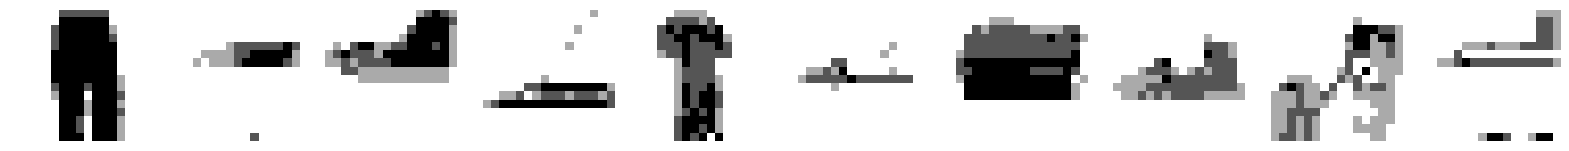

469/469 [==============================] - 27s 58ms/step - loss: 0.3242
Epoch 142/150
469/469 [==============================] - ETA: 0s - loss: 0.3243
Saved to ./output/generated_img_141.png


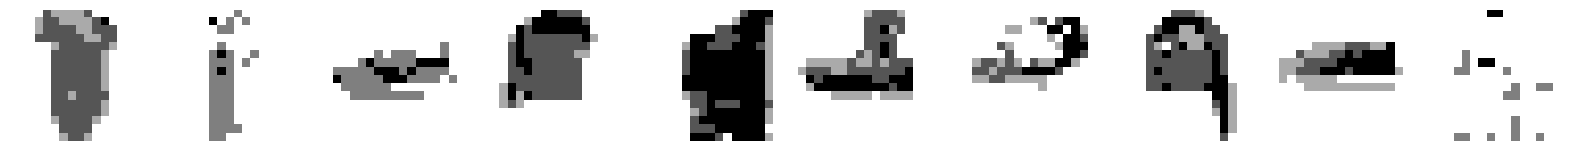

469/469 [==============================] - 25s 54ms/step - loss: 0.3243
Epoch 143/150
467/469 [============================>.] - ETA: 0s - loss: 0.3240
Saved to ./output/generated_img_142.png


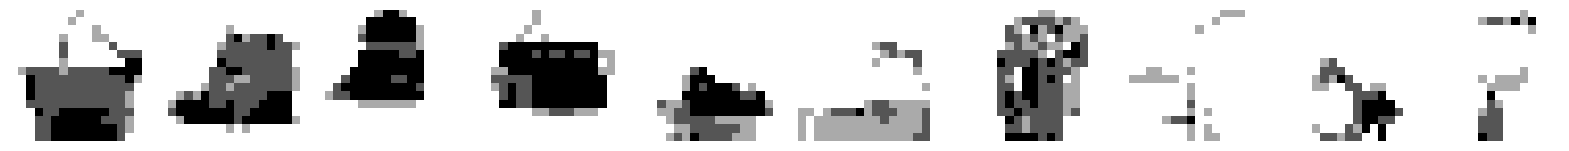

469/469 [==============================] - 28s 60ms/step - loss: 0.3240
Epoch 144/150
466/469 [============================>.] - ETA: 0s - loss: 0.3242
Saved to ./output/generated_img_143.png


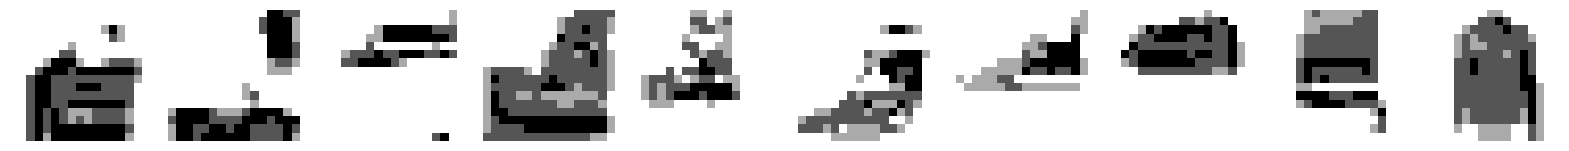

469/469 [==============================] - 26s 54ms/step - loss: 0.3242
Epoch 145/150
466/469 [============================>.] - ETA: 0s - loss: 0.3240
Saved to ./output/generated_img_144.png


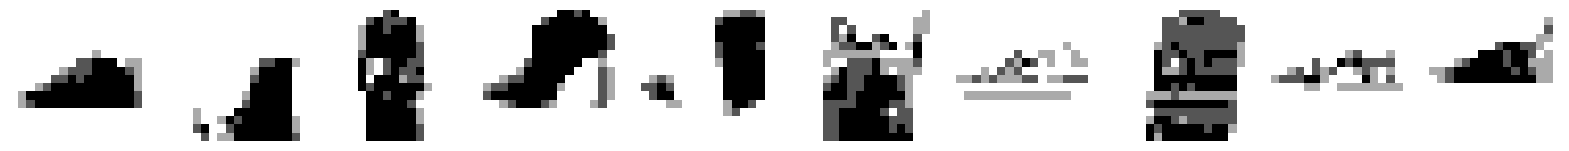

469/469 [==============================] - 25s 54ms/step - loss: 0.3240
Epoch 146/150
467/469 [============================>.] - ETA: 0s - loss: 0.3241
Saved to ./output/generated_img_145.png


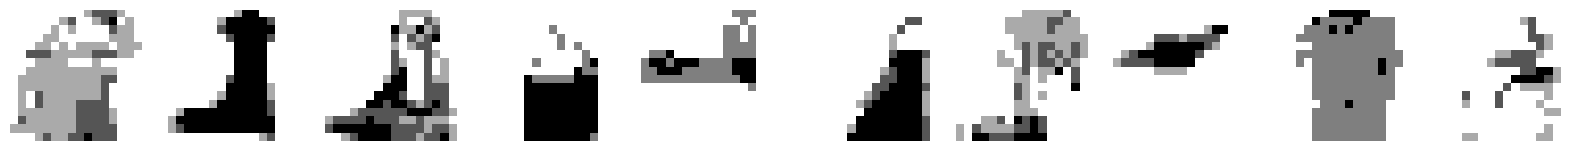

469/469 [==============================] - 28s 59ms/step - loss: 0.3241
Epoch 147/150
468/469 [============================>.] - ETA: 0s - loss: 0.3239
Saved to ./output/generated_img_146.png


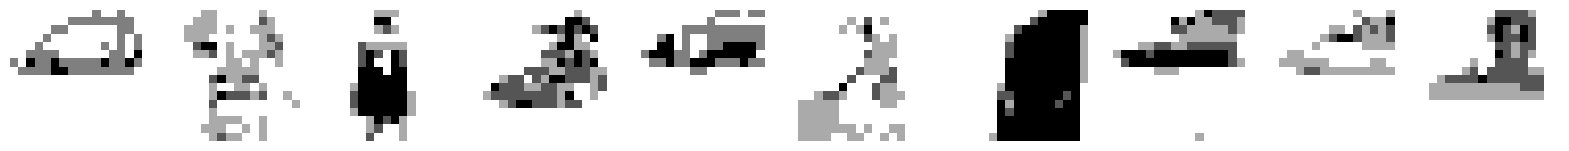

469/469 [==============================] - 25s 54ms/step - loss: 0.3239
Epoch 148/150
468/469 [============================>.] - ETA: 0s - loss: 0.3239
Saved to ./output/generated_img_147.png


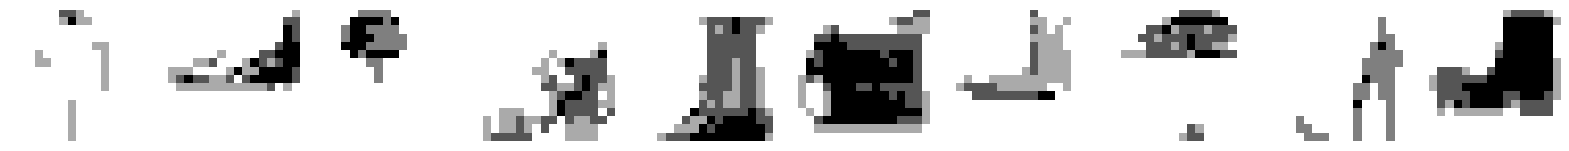

469/469 [==============================] - 28s 60ms/step - loss: 0.3239
Epoch 149/150
466/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_148.png


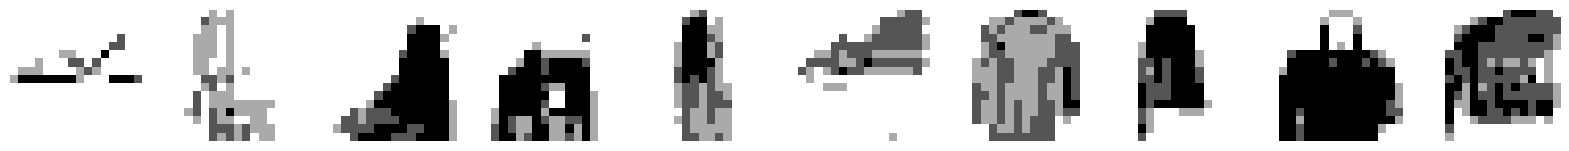

469/469 [==============================] - 26s 55ms/step - loss: 0.3238
Epoch 150/150
468/469 [============================>.] - ETA: 0s - loss: 0.3238
Saved to ./output/generated_img_149.png


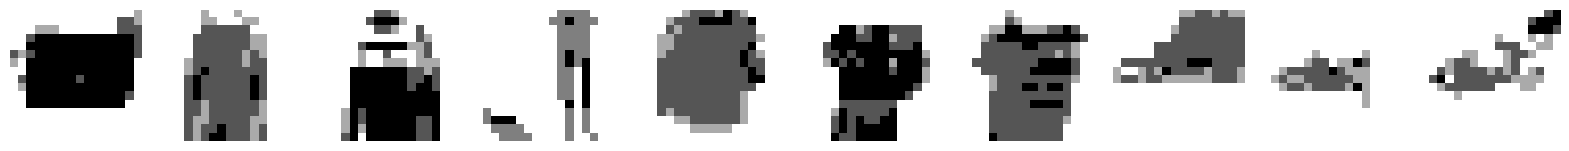

469/469 [==============================] - 25s 54ms/step - loss: 0.3238


In [13]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [14]:
generated_images = img_generator_callback.generate(temperature=1.0)

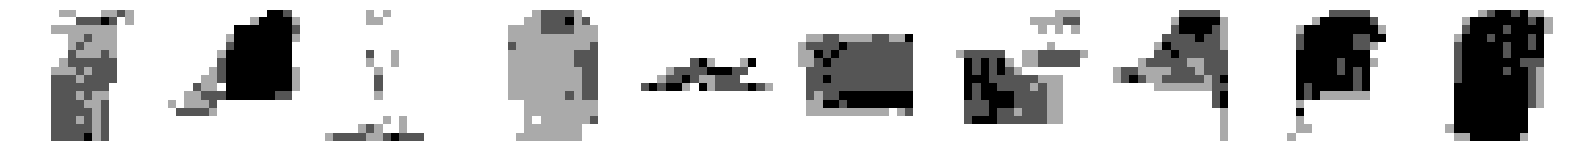

In [15]:
display(generated_images)